In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import TimeSeriesSplit
from datetime import timedelta
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.metrics import r2_score
#Demand Forecasting
from sklearn.linear_model import LinearRegression

from sklearn.metrics import \
    r2_score, get_scorer
from sklearn.linear_model import \
    Lasso, Ridge, LassoCV,LinearRegression
from sklearn.preprocessing import \
    StandardScaler, PolynomialFeatures
from sklearn.model_selection import \
    KFold, RepeatedKFold, GridSearchCV, \
    cross_validate, train_test_split
#linear programmming optimization
from scipy.sparse import csr_matrix, hstack
from scipy.optimize import linprog
from scipy.sparse import lil_matrix
2
tss = TimeSeriesSplit(n_splits = 3)
import matplotlib.pyplot as plt
plt.style.use('seaborn')


In [2]:
dataset_list = ["olist_customers_dataset","olist_geolocation_dataset","olist_order_items_dataset","olist_order_payments_dataset","olist_orders_dataset","olist_products_dataset","product_category_name_translation"]
for csv in dataset_list:
    locals()[csv] = pd.read_csv("C:/Users/akankshasaxena3/Downloads/olist/"+csv+".csv")

In [3]:
olist_products_dataset.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [4]:
olist_orders_dataset.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


# Import product data from Part 1 notebook

In [5]:
product_charateristics_df = pd.read_csv("C:/Users/akankshasaxena3/Downloads/olist/product_charateristics_df_developed_in_easy_way.csv")

In [6]:
product_charateristics_df.columns

Index(['Unnamed: 0', 'product_id', 'order_purchase_timestamp', 'demand',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm'],
      dtype='object')

In [7]:
product_charateristics_df.drop('Unnamed: 0', axis=1, inplace=True)


In [8]:
product_charateristics_df.product_id.nunique()

32951

In [9]:
product_charateristics_df.product_category_name.nunique()

73

In [10]:
# Check for non-finite values
print(product_charateristics_df.isnull().sum())


product_id                       0
order_purchase_timestamp         0
demand                           0
price                            0
freight_value                    0
product_category_name         1399
product_name_lenght           1399
product_description_lenght    1399
product_photos_qty            1399
product_weight_g                16
product_length_cm               16
product_height_cm               16
product_width_cm                16
dtype: int64


In [11]:
product_charateristics_df['product_category_name'] = np.where(product_charateristics_df['product_category_name'].isnull(),'miscellaneous',product_charateristics_df['product_category_name'])
for column in product_charateristics_df.columns:
    if product_charateristics_df[column].isnull().values.any():
        mean_value=product_charateristics_df[column].mean()
        product_charateristics_df[column].fillna(value=mean_value, inplace=True)

The null product categories are imputed with the “miscellaneous” category type. As for other missing product dimensions, they are imputed with mean values

# Time series product clustering

In this section, Product grouping is employed in the context of price elasticity of demand as opposed to demand prediction which is a general scenario. Since the dataset has no dynamic pricing strategy implemented before, only 8% of products in the post-intervention dataset have more than one price point. The PED for such products in the post-intervention dataset is determined by the average PED of the cluster they belong to.
Clustering is applied to the overall dataset including both post and pre-intervention products. The dataset is formatted as a time series by aggregating the following for each product: average price, total sales, maximum price, minimum price, and average sales over three years. Clustering products based on these attributes helps to obtain the products whose demand and prices move similarly over a given period (Bozanta, et al., 2022).

In [144]:
price_count = product_charateristics_df.groupby(['product_id'])['price'].nunique().reset_index(name = 'number of price points')
price_count[price_count['number of price points']>1]['product_id'].nunique()/product_charateristics_df['product_id'].nunique()*100

17.905374647203423

In [13]:
prod_id_price_mean = product_charateristics_df.groupby('product_id')['price'].mean()

In [14]:
grouped = product_charateristics_df.groupby('product_id')

# Create a new DataFrame with the calculated values
summary_df = pd.DataFrame({
    'Average_Price': grouped['price'].mean(),
    'Total_Sales': grouped['demand'].sum(),
    'max_price': grouped['price'].max(),
    'min_price':grouped['price'].min(),
    'average_sales':grouped['demand'].mean()
})

# Reset the index if you want 'product_id' as a column
summary_df.reset_index(inplace=True)

# Display the new DataFrame
summary_df.head()

,product_id,Average_Price,Total_Sales,max_price,min_price,average_sales
0,00066f42aeeb9f3007548bb9d3f33c38,101.65,1,101.65,101.65,1.0
1,00088930e925c41fd95ebfe695fd2655,129.90,1,129.90,129.90,1.0
2,0009406fd7479715e4bef61dd91f2462,229.00,1,229.00,229.00,1.0
3,000b8f95fcb9e0096488278317764d19,58.90,2,58.90,58.90,1.0
4,000d9be29b5207b54e86aa1b1ac54872,199.00,1,199.00,199.00,1.0


In [15]:
summary_df.shape

(32951, 6)

In [16]:
summary_df.columns

Index(['product_id', 'Average_Price', 'Total_Sales', 'max_price', 'min_price',
       'average_sales'],
      dtype='object')

In [17]:
# Check for non-finite values
print(product_charateristics_df.isnull().sum())

product_id                    0
order_purchase_timestamp      0
demand                        0
price                         0
freight_value                 0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64


In [18]:
# Scaling the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(summary_df[['Average_Price', 'Total_Sales', 'max_price', 'min_price','average_sales']])

In [19]:
data_scaled

array([[-0.17685566, -0.16434553, -0.18393598, -0.17074424, -0.27777793],
       [-0.06243244, -0.16434553, -0.07063099, -0.05557492, -0.27777793],
       [ 0.33896018, -0.16434553,  0.32683892,  0.34843499, -0.27777793],
       ...,
       [-0.45896461, -0.16434553, -0.46328794, -0.45469268, -0.27777793],
       [-0.45090435,  0.0632069 , -0.45129566, -0.46288703, -0.27777793],
       [ 0.42397765, -0.16434553,  0.41102553,  0.43400681, -0.27777793]])

In [20]:
list_total_dist_sklearn = []

for i in range(2,31):
    km = KMeans(n_clusters=i, init='random', n_init=10, max_iter=100, random_state=123) # go from 1 to 8 in the value of centroids
    res = km.fit_predict(data_scaled)
    list_total_dist_sklearn.append(km.inertia_) # check how inertia (~total distance) changes as we increase K

list_total_dist_sklearn

[107985.88576433291,
 87146.9673905556,
 68715.53094720904,
 51233.04091496949,
 43330.25536826085,
 35228.934515911074,
 29892.81345068408,
 25274.64039298461,
 22154.812769413937,
 19675.581474913124,
 17183.15092665218,
 15638.499038326363,
 13974.473725174066,
 12854.672414209703,
 11799.093690313497,
 11097.25994503325,
 10648.12887165114,
 10360.598740465939,
 10074.749765743016,
 9621.247559541776,
 9020.361391725206,
 8895.822483033537,
 8700.441463404773,
 8658.288797644067,
 8355.981624968053,
 7873.990305760353,
 7606.522597697788,
 7518.528970447639,
 7445.881749264488]

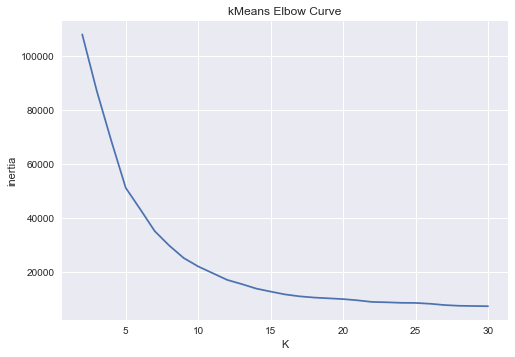

In [21]:
plt.plot(range(2, 31), list_total_dist_sklearn) # from this graph, we can see the sharpest bend at 2 again
plt.title("kMeans Elbow Curve")
plt.ylabel("inertia")
plt.xlabel("K")
plt.show()

In [22]:
km_15 = KMeans(n_clusters=15, init='random', n_init=10, max_iter=100, random_state=123) # go from 1 to 8 in the value of centroids
res_15 = km_15.fit_predict(data_scaled)

In [23]:
score = silhouette_score(data_scaled, km_15.labels_, metric='euclidean')
score

0.4975552448155563

In [24]:
summary_df['cluster'] = res_15

In [25]:
summary_df

,product_id,Average_Price,Total_Sales,max_price,min_price,average_sales,cluster
0,00066f42aeeb9f3007548bb9d3f33c38,101.65,1,101.65,101.65,1.0,9
1,00088930e925c41fd95ebfe695fd2655,129.90,1,129.90,129.90,1.0,9
2,0009406fd7479715e4bef61dd91f2462,229.00,1,229.00,229.00,1.0,11
3,000b8f95fcb9e0096488278317764d19,58.90,2,58.90,58.90,1.0,3
4,000d9be29b5207b54e86aa1b1ac54872,199.00,1,199.00,199.00,1.0,11
...,...,...,...,...,...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,114.99,2,119.99,109.99,1.0,9
32947,fff81cc3158d2725c0655ab9ba0f712c,90.00,1,90.00,90.00,1.0,9
32948,fff9553ac224cec9d15d49f5a263411f,32.00,1,32.00,32.00,1.0,3
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,33.99,5,34.99,29.99,1.0,3


In [26]:
summary_df['cluster'].unique()
# we have 15 clusters which start from 0 till 14

array([ 9, 11,  3,  8,  7,  5,  4, 14,  0, 13, 12,  1,  2, 10,  6])

In [27]:
cluster_series = summary_df.set_index('product_id')['cluster']
cluster_series

product_id
00066f42aeeb9f3007548bb9d3f33c38     9
00088930e925c41fd95ebfe695fd2655     9
0009406fd7479715e4bef61dd91f2462    11
000b8f95fcb9e0096488278317764d19     3
000d9be29b5207b54e86aa1b1ac54872    11
                                    ..
fff6177642830a9a94a0f2cba5e476d1     9
fff81cc3158d2725c0655ab9ba0f712c     9
fff9553ac224cec9d15d49f5a263411f     3
fffdb2d0ec8d6a61f0a0a0db3f25b441     3
fffe9eeff12fcbd74a2f2b007dde0c58    11
Name: cluster, Length: 32951, dtype: int32

In [28]:
product_charateristics_df['cluster'] = product_charateristics_df['product_id'].map(cluster_series)

In [29]:
sanity_check = product_charateristics_df.groupby('product_id')['cluster'].nunique()

In [30]:
sanity_check[sanity_check==1]
## sanity check to see if each product id is assigned to only one cluster

product_id
00066f42aeeb9f3007548bb9d3f33c38    1
00088930e925c41fd95ebfe695fd2655    1
0009406fd7479715e4bef61dd91f2462    1
000b8f95fcb9e0096488278317764d19    1
000d9be29b5207b54e86aa1b1ac54872    1
                                   ..
fff6177642830a9a94a0f2cba5e476d1    1
fff81cc3158d2725c0655ab9ba0f712c    1
fff9553ac224cec9d15d49f5a263411f    1
fffdb2d0ec8d6a61f0a0a0db3f25b441    1
fffe9eeff12fcbd74a2f2b007dde0c58    1
Name: cluster, Length: 32951, dtype: int64

In [31]:
product_charateristics_df[product_charateristics_df['cluster'] == 0].shape

(1429, 14)

In [32]:
product_charateristics_df[product_charateristics_df['cluster'] == 1]['product_category_name'].unique()

array(['portateis_casa_forno_e_cafe', 'bebes', 'eletronicos',
       'beleza_saude', 'esporte_lazer', 'miscellaneous',
       'eletroportateis', 'cool_stuff', 'ferramentas_jardim',
       'instrumentos_musicais', 'pcs', 'agro_industria_e_comercio',
       'pet_shop', 'relogios_presentes', 'informatica_acessorios',
       'cama_mesa_banho', 'automotivo',
       'construcao_ferramentas_construcao',
       'construcao_ferramentas_seguranca', 'moveis_decoracao',
       'market_place', 'industria_comercio_e_negocios',
       'eletrodomesticos_2', 'utilidades_domesticas', 'telefonia',
       'eletrodomesticos', 'construcao_ferramentas_ferramentas'],
      dtype=object)

In [33]:
product_charateristics_df.groupby('cluster')['product_id'].nunique().reset_index()

,cluster,product_id
0,0,698
1,1,116
2,2,17
3,3,14173
4,4,397
5,5,131
6,6,9
7,7,2394
8,8,1703
9,9,7763


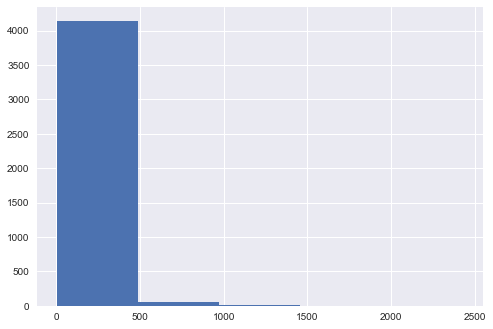

In [34]:
plt.hist(product_charateristics_df[product_charateristics_df['product_category_name'] == 'telefonia']['price'], bins=5)
plt.show()

In [35]:
product_charateristics_df[product_charateristics_df['cluster'] == 14]['price'].describe()

count    3076.000000
mean      451.871622
std        83.701369
min       249.900000
25%       385.515000
50%       429.000000
75%       514.990000
max       729.000000
Name: price, dtype: float64

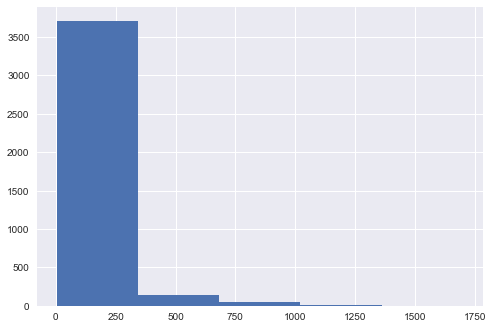

In [36]:
plt.hist(product_charateristics_df[product_charateristics_df['product_category_name'] == 'brinquedos']['price'], bins=5)
plt.show()

In [37]:
product_charateristics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99625 entries, 0 to 99624
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  99625 non-null  object 
 1   order_purchase_timestamp    99625 non-null  object 
 2   demand                      99625 non-null  int64  
 3   price                       99625 non-null  float64
 4   freight_value               99625 non-null  float64
 5   product_category_name       99625 non-null  object 
 6   product_name_lenght         99625 non-null  float64
 7   product_description_lenght  99625 non-null  float64
 8   product_photos_qty          99625 non-null  float64
 9   product_weight_g            99625 non-null  float64
 10  product_length_cm           99625 non-null  float64
 11  product_height_cm           99625 non-null  float64
 12  product_width_cm            99625 non-null  float64
 13  cluster                     996

In [38]:
product_charateristics_df.product_id.nunique()

32951

In [39]:
product_charateristics_df.product_category_name.nunique()

74

In [40]:
product_charateristics_df.order_purchase_timestamp.min(),product_charateristics_df.order_purchase_timestamp.max()

('2016-09-04', '2018-09-03')

In [41]:
sorted_df = product_charateristics_df.sort_values("order_purchase_timestamp")

In [42]:
split_index = int(len(sorted_df) * 0.6)


In [43]:
# Split the data
X_train = sorted_df.iloc[:split_index]
X_test = sorted_df.iloc[split_index:]


In [145]:
price_count_post_intervention = X_test.groupby(['product_id'])['price'].nunique().reset_index(name = 'number of price points')
price_count_post_intervention[price_count_post_intervention['number of price points']>1]['product_id'].nunique()/X_test['product_id'].nunique()*100

11.98468258242087

In [146]:
price_count_pre_intervention = X_train.groupby(['product_id'])['price'].nunique().reset_index(name = 'number of price points')
price_count_pre_intervention[price_count_pre_intervention['number of price points']>1]['product_id'].nunique()/X_train['product_id'].nunique()*100

15.395846088635615

only 12% of products in the post-intervention dataset have more than one price point and 15% in pre-intervention have more than one price point

X_train data is the pre-intervention dataset and X_test is post-intervention dataset. Pre-intervention dataset will be used to train models to fit on test data.Price elasticity of demand,and Demand forecast model are calibrated on pre-intervention dataset to provide historical context for post-intervention dataset. In the final step of linear programming optimization,optimal prices are determined for only post-intervention dataset, keeping the prices for pre-intervention dataset at base price.

In [46]:
X_train.product_id.nunique(),X_test.product_id.nunique(),

(21233, 16713)

In [47]:
X_train.product_id.shape,X_test.product_id.shape

((59775,), (39850,))

In [48]:
X_train.order_purchase_timestamp.min(),X_train.order_purchase_timestamp.max()

('2016-09-04', '2018-03-02')

In [49]:
X_train.shape,X_test.shape

((59775, 14), (39850, 14))

In [50]:
X_test.order_purchase_timestamp.min(),X_test.order_purchase_timestamp.max()

('2018-03-02', '2018-09-03')

In [51]:
X_test.columns

Index(['product_id', 'order_purchase_timestamp', 'demand', 'price',
       'freight_value', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'cluster'],
      dtype='object')

# Preprocessing and Feature Engineering

## Categorical variable 

In [52]:
# Frequency encoding
frequency_encoding = X_train['product_category_name'].value_counts(normalize=True)
X_train['category_frequency'] = X_train['product_category_name'].map(frequency_encoding)

# Mean encoding
mean_encoding = X_train.groupby('product_category_name')['demand'].mean()
X_train['category_mean_demand'] = X_train['product_category_name'].map(mean_encoding)

X_train.head() 

C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\2752387914.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['category_frequency'] = X_train['product_category_name'].map(frequency_encoding)
C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\2752387914.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['category_mean_demand'] = X_train['product_category_name'].map(mean_encoding)


,product_id,order_purchase_timestamp,demand,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,cluster,category_frequency,category_mean_demand
75098,c1488892604e4ba5cff5b4eb4d595400,2016-09-04,1,39.99,31.67,moveis_decoracao,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,7,0.070498,1.426910
94385,f293394c72c9b5fafd7023301fc21fc2,2016-09-04,1,32.90,31.67,moveis_decoracao,41.0,754.0,3.0,1800.0,32.0,6.0,28.0,3,0.070498,1.426910
94841,f3c2d01a84c947b078e32bbef0718962,2016-09-05,1,59.50,15.56,telefonia,42.0,381.0,1.0,700.0,25.0,2.0,25.0,3,0.046156,1.223269
36093,5a6b04657a4c5ee34285d1e4619a96b4,2016-09-15,3,44.99,2.83,beleza_saude,34.0,1036.0,1.0,1000.0,16.0,16.0,16.0,8,0.077072,1.309746
82501,d2998d7ced12f83f9b832f33cf6507b6,2016-10-02,1,100.00,9.34,bebes,32.0,561.0,1.0,500.0,18.0,18.0,18.0,9,0.027152,1.120764


In [53]:
# Frequency encoding
frequency_encoding = X_test['product_category_name'].value_counts(normalize=True)
X_test['category_frequency'] = X_test['product_category_name'].map(frequency_encoding)

# Mean encoding
mean_encoding = X_test.groupby('product_category_name')['demand'].mean()
X_test['category_mean_demand'] = X_test['product_category_name'].map(mean_encoding)

X_test.head()  

C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\2224264191.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['category_frequency'] = X_test['product_category_name'].map(frequency_encoding)
C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\2224264191.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['category_mean_demand'] = X_test['product_category_name'].map(mean_encoding)


,product_id,order_purchase_timestamp,demand,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,cluster,category_frequency,category_mean_demand
72969,bb50f2e236e5eea0100680137654686c,2018-03-02,3,325.00,27.55,beleza_saude,60.0,2644.0,6.0,400.0,34.0,4.0,22.0,10,0.103714,1.381563
72970,bb50f2e236e5eea0100680137654686c,2018-03-02,3,325.00,18.71,beleza_saude,60.0,2644.0,6.0,400.0,34.0,4.0,22.0,10,0.103714,1.381563
10092,19c91ef95d509ea33eda93495c4d3481,2018-03-02,1,110.99,44.63,beleza_saude,50.0,1257.0,1.0,700.0,25.0,12.0,19.0,10,0.103714,1.381563
44942,71a5f1c2a5fd9889ef26b5ac22aec9c6,2018-03-02,1,19.90,26.16,moveis_decoracao,60.0,500.0,3.0,100.0,16.0,3.0,11.0,7,0.059297,1.407956
20843,368c6c730842d78016ad823897a372db,2018-03-02,4,53.90,13.40,ferramentas_jardim,57.0,366.0,2.0,1650.0,30.0,22.0,30.0,6,0.026851,1.461682


## rolling window demand for last 7 days

a non-static time-based feature using rolling windows is formulated to use the aggregate demand of the past week as an attribute Past demand incorporates the demands over the previous  days. In the experiment, a period of days t=7 is selected to account for the previous week of demand data. 

In [54]:
count = product_charateristics_df.groupby(['product_id']).size().reset_index(name = 'count')

In [55]:
count[count['count'] > 1]

,product_id,count
3,000b8f95fcb9e0096488278317764d19,2
6,00126f27c813603687e6ce486d909d01,2
7,001795ec6f1b187d37335e1c4704762e,7
9,001b72dfd63e9833e8c02742adf472e3,12
11,00210e41887c2a8ef9f791ebc780cc36,4
...,...,...
32940,ffedbd68fa6f44e788ff6c2db8094715,5
32941,ffef256879dbadcab7e77950f4f4a195,4
32942,fff0a542c3c62682f23305214eaeaa24,4
32946,fff6177642830a9a94a0f2cba5e476d1,2


In [56]:
X_test[['product_id','order_purchase_timestamp']].drop_duplicates().shape,X_test[['product_id','order_purchase_timestamp']].shape

((37889, 2), (39850, 2))

In [57]:
X_test[['product_id','order_purchase_timestamp']].duplicated().sum()

1961

In [58]:
X_test.duplicated().sum()

0

In [59]:
timestamp_distribution = product_charateristics_df.groupby('product_id')['order_purchase_timestamp'].nunique().reset_index()

In [60]:
X_test[X_test[['product_id','order_purchase_timestamp']].duplicated()]

,product_id,order_purchase_timestamp,demand,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,cluster,category_frequency,category_mean_demand
72970,bb50f2e236e5eea0100680137654686c,2018-03-02,3,325.0,18.71,beleza_saude,60.0,2644.0,6.0,400.0,34.0,4.0,22.0,10,0.103714,1.381563
72971,bb50f2e236e5eea0100680137654686c,2018-03-02,3,325.0,17.02,beleza_saude,60.0,2644.0,6.0,400.0,34.0,4.0,22.0,10,0.103714,1.381563
37507,5d92abea542c2022dfee91dd630f2697,2018-03-02,2,112.0,15.54,cama_mesa_banho,57.0,261.0,2.0,1580.0,66.0,13.0,45.0,7,0.096487,1.183355
98072,fbc1488c1a1e72ba175f53ab29a248e8,2018-03-02,2,119.8,14.59,perfumaria,27.0,311.0,1.0,560.0,19.0,13.0,17.0,12,0.026901,1.207090
29492,4a7056788ce9287c76ade358f2e2572a,2018-03-02,3,21.9,12.35,artigos_de_festas,56.0,186.0,6.0,100.0,16.0,6.0,11.0,8,0.000678,1.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,06601c3059e35a3bf65e72f2fd2ac626,2018-08-24,2,109.9,16.96,alimentos,60.0,523.0,4.0,750.0,28.0,11.0,13.0,7,0.006876,1.565693
7637,145978af3e89b318be0b717a0953649a,2018-08-25,2,20.9,12.81,informatica_acessorios,56.0,295.0,3.0,150.0,31.0,3.0,28.0,7,0.063864,1.519450
64486,a59fb60fddcc72a9878b7ed5cb69d8e4,2018-08-26,2,14.9,15.23,audio,48.0,424.0,1.0,200.0,27.0,5.0,20.0,12,0.003438,1.357664
7639,145978af3e89b318be0b717a0953649a,2018-08-26,2,20.9,12.81,informatica_acessorios,56.0,295.0,3.0,150.0,31.0,3.0,28.0,7,0.063864,1.519450


In [61]:
timestamp_distribution[timestamp_distribution['order_purchase_timestamp']>=21].shape[0]/timestamp_distribution.shape[0]*100

1.5143698218566963

In [62]:
timestamp_distribution[timestamp_distribution['order_purchase_timestamp']>=14].shape[0]/timestamp_distribution.shape[0]*100

2.901277654699402

In [63]:
timestamp_distribution[timestamp_distribution['order_purchase_timestamp']>7].shape[0]/timestamp_distribution.shape[0]*100

6.430760826682043

Only 6% of the overall dataset(including both post- and pre-intervention data) has more than a week of history of purchase information. 

In [64]:
timestamp_distribution['order_purchase_timestamp'].describe()

count    32951.000000
mean         2.870656
std          6.707658
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        268.000000
Name: order_purchase_timestamp, dtype: float64

In [65]:
timestamp_distribution.shape[0]

32951

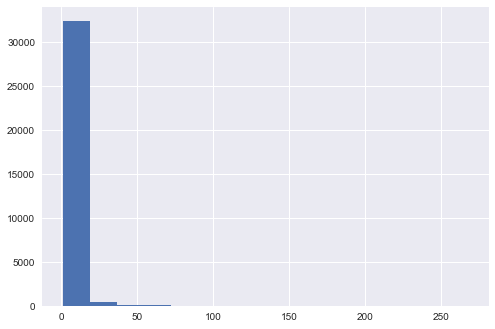

In [66]:
plt.hist(timestamp_distribution['order_purchase_timestamp'], bins=15)
plt.show()

In [67]:
def rolling_window_price_and_demand(df):
    # Sort values by 'product' and 'timestamp'
    df_sorted = df.sort_values(by=['product_id', 'order_purchase_timestamp'])
    # Drop duplicates based on 'product' and 'timestamp', keep the first
    df_deduped = df_sorted.drop_duplicates(subset=['product_id', 'order_purchase_timestamp'], keep='first')
    rolling_df_price = df_deduped.groupby(['product_id']).rolling(window = 3,min_periods=1, on='order_purchase_timestamp')['price'].mean().reset_index(name = 'avg_price_last_3_days').drop_duplicates()
    cumulative_demand_df = df_deduped.groupby(['product_id']).rolling(
        window=7, min_periods=1, on='order_purchase_timestamp'
    )['demand'].sum().reset_index(name='cumulative_demand').drop_duplicates(['product_id', 'order_purchase_timestamp'])
    rolling_window_final = pd.merge(
        rolling_df_price,
        cumulative_demand_df,
        on=['product_id', 'order_purchase_timestamp'],
        how='inner'
    )
    
    return rolling_window_final

In [68]:
rolling_window_train = rolling_window_price_and_demand(X_train)
rolling_window_test = rolling_window_price_and_demand(X_test)

In [69]:
X_test.shape,X_train.shape

((39850, 16), (59775, 16))

In [70]:
X_test = pd.merge(
        X_test,
        rolling_window_test,
        on=['product_id', 'order_purchase_timestamp'],
        how='left'
    )

X_train = pd.merge(
        X_train,
        rolling_window_train,
        on=['product_id', 'order_purchase_timestamp'],
        how='left'
    )

In [71]:
X_test.shape,X_train.shape

((39850, 18), (59775, 18))

## Adding time features

For capturing patterns and trends in demand, and also for capturing seasonality which is useful for demand prediction, time-based features are added to the dataset. The following features were extracted from the feature order purchase timestamp: weekday name and number, month name and number, year number, and week number. 

In [72]:
def add_features(data):
    data['revenue'] = data['demand']*data['price']
    #time features
    data['weekday_name'] = pd.to_datetime(data['order_purchase_timestamp'],errors='coerce').dt.day_name()
    data['weekday_number']=pd.to_datetime(data['order_purchase_timestamp'],errors='coerce').dt.weekday
    data['month_number']=pd.to_datetime(data['order_purchase_timestamp'],errors='coerce').dt.month
    data['month_name']=pd.to_datetime(data['order_purchase_timestamp'],errors='coerce').dt.month_name()
    data['year_number']=pd.to_datetime(data['order_purchase_timestamp'],errors='coerce').dt.year
    data['week_year']=pd.to_datetime(data['order_purchase_timestamp'],errors='coerce').dt.to_period('W')
    data['week_number']=pd.to_datetime(data['order_purchase_timestamp'],errors='coerce').dt.isocalendar().week
    return data

In [73]:
X_test = add_features(X_test)
X_train = add_features(X_train)


In [74]:
product_charateristics_df = add_features(product_charateristics_df)

In [75]:
product_charateristics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99625 entries, 0 to 99624
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype        
---  ------                      --------------  -----        
 0   product_id                  99625 non-null  object       
 1   order_purchase_timestamp    99625 non-null  object       
 2   demand                      99625 non-null  int64        
 3   price                       99625 non-null  float64      
 4   freight_value               99625 non-null  float64      
 5   product_category_name       99625 non-null  object       
 6   product_name_lenght         99625 non-null  float64      
 7   product_description_lenght  99625 non-null  float64      
 8   product_photos_qty          99625 non-null  float64      
 9   product_weight_g            99625 non-null  float64      
 10  product_length_cm           99625 non-null  float64      
 11  product_height_cm           99625 non-null  float64      
 12  prod

In [76]:
# Step 3: Aggregate the demand by year and month
monthly_demand = product_charateristics_df.groupby(['year_number', 'month_number'])['demand'].sum().reset_index()

In [77]:
monthly_demand['date_str'] = monthly_demand['month_number'].astype(str).str.zfill(2) + '-' + monthly_demand['year_number'].astype(str)


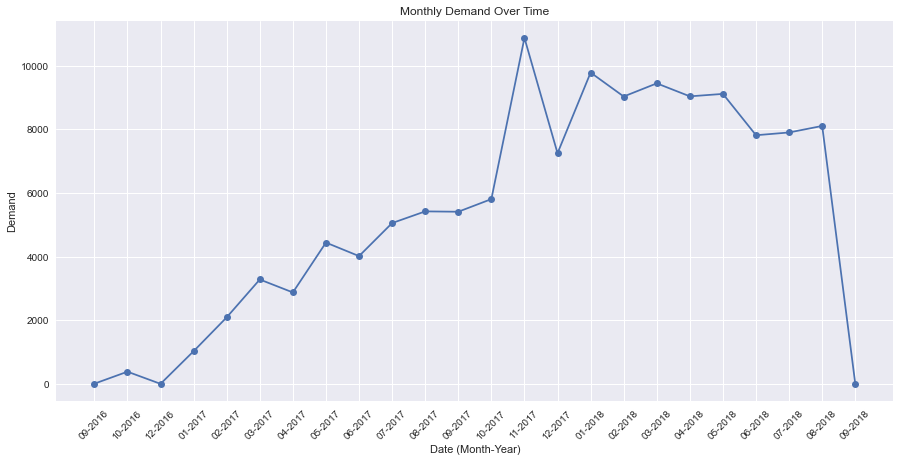

In [78]:
plt.figure(figsize=(15, 7))  # Adjust the size of the plot as needed
plt.plot(monthly_demand['date_str'], monthly_demand['demand'], marker='o', linestyle='-')

# Formatting the plot
plt.title('Monthly Demand Over Time')
plt.xlabel('Date (Month-Year)')
plt.ylabel('Demand')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Show the plot
plt.show()

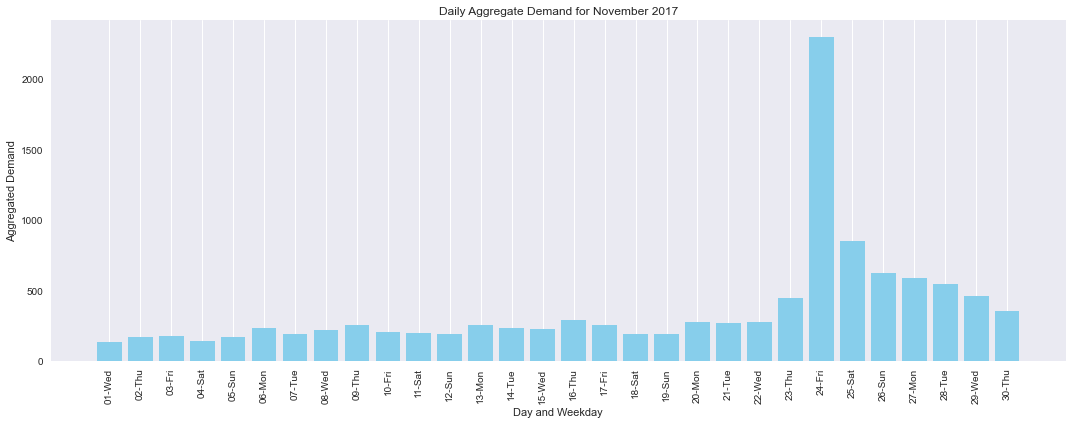

In [79]:
# Assuming your DataFrame is named product_characteristics_df
# Convert 'order_purchase_timestamp' to datetime just to be safe
product_charateristics_df['order_purchase_timestamp'] = pd.to_datetime(product_charateristics_df['order_purchase_timestamp'])

# Filter for November 2017
november_2017_data = product_charateristics_df[
    (product_charateristics_df['order_purchase_timestamp'].dt.year == 2017) &
    (product_charateristics_df['order_purchase_timestamp'].dt.month == 11)
]

# Group by each day and sum the demand
daily_demand_november_2017 = november_2017_data.groupby(november_2017_data['order_purchase_timestamp'].dt.date)['demand'].sum().reset_index(name='daily_demand')

# Ensure 'order_purchase_timestamp' is a datetime for .dt accessor
daily_demand_november_2017['order_purchase_timestamp'] = pd.to_datetime(daily_demand_november_2017['order_purchase_timestamp'])

# Add a column for day and weekday name
daily_demand_november_2017['day_weekday'] = daily_demand_november_2017['order_purchase_timestamp'].dt.strftime('%d-%a')

# Plot the time series graph
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
plt.bar(daily_demand_november_2017['day_weekday'], daily_demand_november_2017['daily_demand'], color='skyblue')

# Formatting the plot
plt.title('Daily Aggregate Demand for November 2017')
plt.xlabel('Day and Weekday')
plt.ylabel('Aggregated Demand')
plt.grid(axis='y')

# Rotate x-axis labels vertically
plt.xticks(rotation=90)

# Improve spacing to accommodate the rotated x-axis labels
plt.tight_layout()

# Display the plot
plt.show()


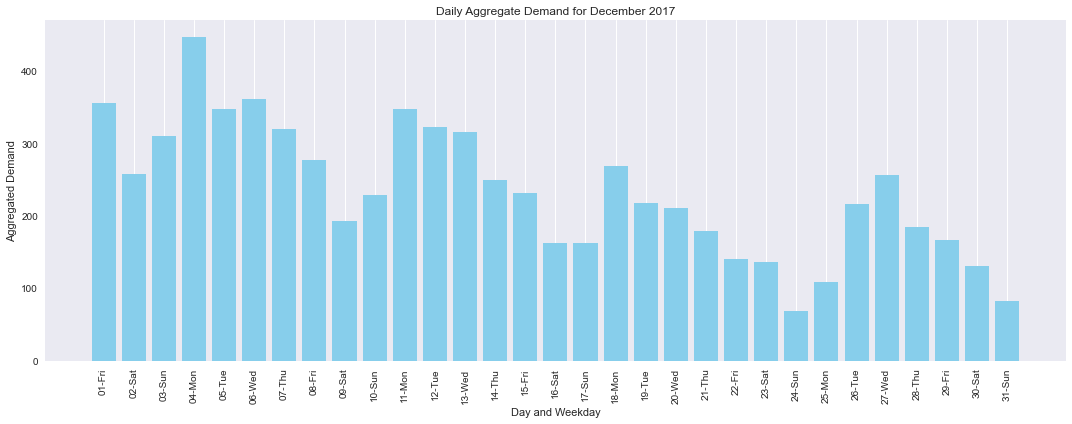

In [80]:
# Filter for December 2017
December_2017_data = product_charateristics_df[
    (product_charateristics_df['order_purchase_timestamp'].dt.year == 2017) &
    (product_charateristics_df['order_purchase_timestamp'].dt.month == 12)
]

# Group by each day and sum the demand
daily_demand_December_2017 = December_2017_data.groupby(December_2017_data['order_purchase_timestamp'].dt.date)['demand'].sum().reset_index(name='daily_demand')

# Ensure 'order_purchase_timestamp' is a datetime for .dt accessor
daily_demand_December_2017['order_purchase_timestamp'] = pd.to_datetime(daily_demand_December_2017['order_purchase_timestamp'])

# Add a column for day and weekday name
daily_demand_December_2017['day_weekday'] = daily_demand_December_2017['order_purchase_timestamp'].dt.strftime('%d-%a')

# Plot the time series graph
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
plt.bar(daily_demand_December_2017['day_weekday'], daily_demand_December_2017['daily_demand'], color='skyblue')

# Formatting the plot
plt.title('Daily Aggregate Demand for December 2017')
plt.xlabel('Day and Weekday')
plt.ylabel('Aggregated Demand')
plt.grid(axis='y')

# Rotate x-axis labels vertically
plt.xticks(rotation=90)

# Improve spacing to accommodate the rotated x-axis labels
plt.tight_layout()

# Display the plot
plt.show()


## Adding holiday column

Further, the holiday feature is also integrated into the dataset using the holiday library in Python. This is a Python package designed to dynamically generate lists of official holidays for countries and their subdivisions, such as states or provinces

In [81]:
pip install --upgrade holidays


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [84]:
#holiday flag
import holidays
from holidays.constants import PUBLIC, UNOFFICIAL
from holidays.countries.brazil import BR

In [85]:
brazil_holidays = holidays.BR()

In [86]:
brazil_holidays

holidays.country_holidays('BR')

In [87]:
brazil_holidays = holidays.country_holidays('BR')  # this is a dict


In [88]:
brazil_holidays.get('2018-01-01')

'Confraternização Universal'

In [89]:
holiday_list = []
for holiday in holidays.Brazil(years=[2016, 2017,2018]).items():
    holiday_list.append(holiday)

holidays_df = pd.DataFrame(holiday_list, columns=["date", "holiday"])
holidays_df

,date,holiday
0,2016-01-01,Confraternização Universal
1,2016-03-25,Sexta-feira Santa
2,2016-04-21,Tiradentes
3,2016-05-01,Dia do Trabalhador
4,2016-09-07,Independência do Brasil
5,2016-10-12,Nossa Senhora Aparecida
6,2016-11-02,Finados
7,2016-11-15,Proclamação da República
8,2016-12-25,Natal
9,2017-01-01,Confraternização Universal


In [90]:
expanded_data = {'date': []}

for index, row in holidays_df.iterrows():
    current_date = row['date']
    
    # Add the current date and its holiday name
    expanded_data['date'].append(current_date)
    
    # Find the dates for the previous 5 days and assign the same holiday name
    for delta in range(-7, 7):
        previous_date = current_date + timedelta(days=delta)
        expanded_data['date'].append(previous_date)

In [91]:
holidays_df = pd.DataFrame(expanded_data, columns=["date"])
holidays_df

,date
0,2016-01-01
1,2015-12-25
2,2015-12-26
3,2015-12-27
4,2015-12-28
...,...
400,2018-12-27
401,2018-12-28
402,2018-12-29
403,2018-12-30


In [92]:
holidays_df['date'] = pd.to_datetime(holidays_df['date']) 

In [93]:
X_train['order_purchase_timestamp']=pd.to_datetime(X_train['order_purchase_timestamp'])
X_test['order_purchase_timestamp']=pd.to_datetime(X_test['order_purchase_timestamp'])

In [94]:
X_train['is_holiday']=X_train['order_purchase_timestamp'].isin(holidays_df['date'])
X_test['is_holiday']=X_test['order_purchase_timestamp'].isin(holidays_df['date'])

In [95]:
X_train[X_train['is_holiday']==True]['is_holiday'].sum()

14951

In [96]:
X_train['order_purchase_timestamp'].max(),X_train['order_purchase_timestamp'].min()

(Timestamp('2018-03-02 00:00:00'), Timestamp('2016-09-04 00:00:00'))

In [97]:
X_test['order_purchase_timestamp'].max(),X_test['order_purchase_timestamp'].min()

(Timestamp('2018-09-03 00:00:00'), Timestamp('2018-03-02 00:00:00'))

## Product market trend features

In [98]:
X_train['sales_margin']=X_train['revenue'] - (X_train['freight_value']*X_train['demand'])
X_train['log_price'] = np.log(X_train['price'])
X_train['log_revenue'] = np.log(X_train['revenue'])
X_train['log_demand'] = np.log(X_train['demand']+1)

In [99]:
X_test['sales_margin']=X_test['revenue'] - (X_test['freight_value']*X_test['demand'])
X_test['log_price'] = np.log(X_test['price'])
X_test['log_revenue'] = np.log(X_test['revenue'])

X_test['log_demand'] = np.log(X_test['demand']+1)


# Data preprocessing

## Handling null values

In [100]:
X_train.columns

Index(['product_id', 'order_purchase_timestamp', 'demand', 'price',
       'freight_value', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm', 'cluster',
       'category_frequency', 'category_mean_demand', 'avg_price_last_3_days',
       'cumulative_demand', 'revenue', 'weekday_name', 'weekday_number',
       'month_number', 'month_name', 'year_number', 'week_year', 'week_number',
       'is_holiday', 'sales_margin', 'log_price', 'log_revenue', 'log_demand'],
      dtype='object')

In [101]:
for column in X_train.columns:
    print("column = "+column+" has "+str(X_train[column].isnull().sum())+" null values")

column = product_id has 0 null values
column = order_purchase_timestamp has 0 null values
column = demand has 0 null values
column = price has 0 null values
column = freight_value has 0 null values
column = product_category_name has 0 null values
column = product_name_lenght has 0 null values
column = product_description_lenght has 0 null values
column = product_photos_qty has 0 null values
column = product_weight_g has 0 null values
column = product_length_cm has 0 null values
column = product_height_cm has 0 null values
column = product_width_cm has 0 null values
column = cluster has 0 null values
column = category_frequency has 0 null values
column = category_mean_demand has 0 null values
column = avg_price_last_3_days has 0 null values
column = cumulative_demand has 0 null values
column = revenue has 0 null values
column = weekday_name has 0 null values
column = weekday_number has 0 null values
column = month_number has 0 null values
column = month_name has 0 null values
column = y

In [102]:
for column in X_test.columns:
    print("column = "+column+" has "+str(X_test[column].isnull().sum())+" null values")

column = product_id has 0 null values
column = order_purchase_timestamp has 0 null values
column = demand has 0 null values
column = price has 0 null values
column = freight_value has 0 null values
column = product_category_name has 0 null values
column = product_name_lenght has 0 null values
column = product_description_lenght has 0 null values
column = product_photos_qty has 0 null values
column = product_weight_g has 0 null values
column = product_length_cm has 0 null values
column = product_height_cm has 0 null values
column = product_width_cm has 0 null values
column = cluster has 0 null values
column = category_frequency has 0 null values
column = category_mean_demand has 0 null values
column = avg_price_last_3_days has 0 null values
column = cumulative_demand has 0 null values
column = revenue has 0 null values
column = weekday_name has 0 null values
column = weekday_number has 0 null values
column = month_number has 0 null values
column = month_name has 0 null values
column = y

In [103]:
pd.set_option('display.max_columns', None)


## Outlier detection and handling

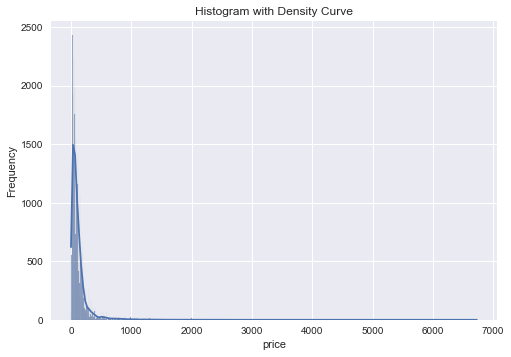

In [105]:
sns.histplot(X_test['price'], kde=True)

# Customizations (optional)
plt.title("Histogram with Density Curve")
plt.xlabel("price")
plt.ylabel("Frequency")

# Display the plot
plt.show()

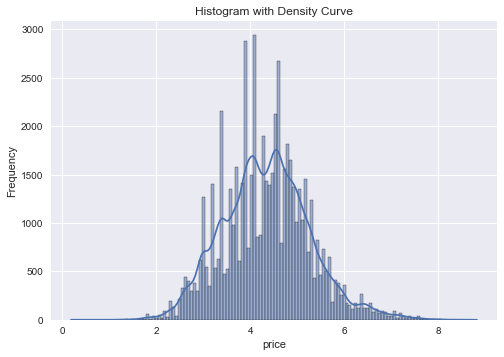

In [106]:
sns.histplot(X_train['log_price'], kde=True)

# Customizations (optional)
plt.title("Histogram with Density Curve")
plt.xlabel("price")
plt.ylabel("Frequency")

# Display the plot
plt.show()

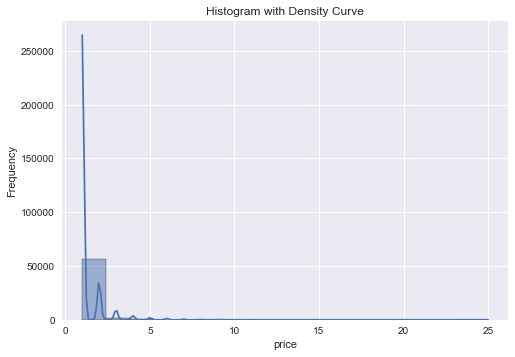

In [107]:
sns.histplot(X_train['demand'], kde=True)

# Customizations (optional)
plt.title("Histogram with Density Curve")
plt.xlabel("price")
plt.ylabel("Frequency")

# Display the plot
plt.show()

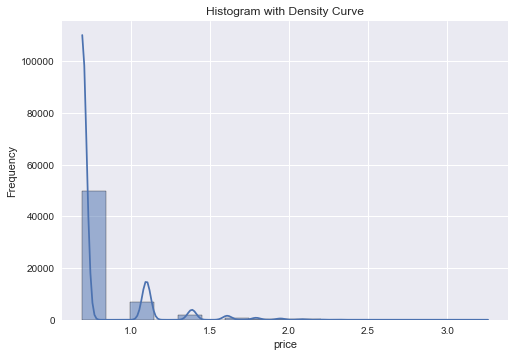

In [108]:
sns.histplot(X_train['log_demand'], kde=True)

# Customizations (optional)
plt.title("Histogram with Density Curve")
plt.xlabel("price")
plt.ylabel("Frequency")

# Display the plot
plt.show()

In [109]:

stats.normaltest(X_train['demand']),stats.normaltest(X_train['log_demand'])

(NormaltestResult(statistic=83531.86249538175, pvalue=0.0),
 NormaltestResult(statistic=40970.03407624678, pvalue=0.0))

In [110]:
stats.normaltest(X_train['price']),stats.normaltest(X_train['log_price'])

(NormaltestResult(statistic=82625.16656313639, pvalue=0.0),
 NormaltestResult(statistic=914.989837270858, pvalue=2.0534367859707497e-199))

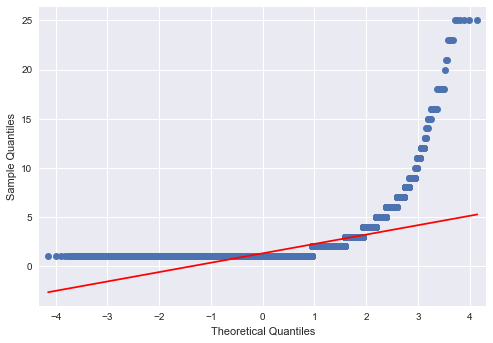

In [111]:
qqplot(X_train['demand'], line='s')
plt.show()

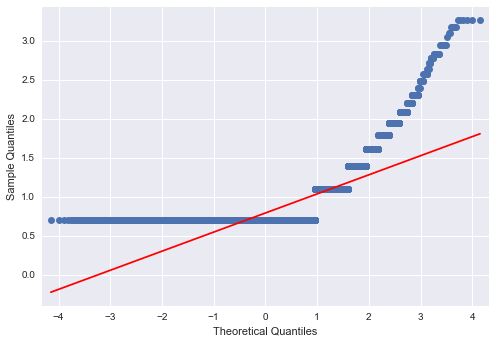

In [112]:
qqplot(X_train['log_demand'], line='s')
plt.show()

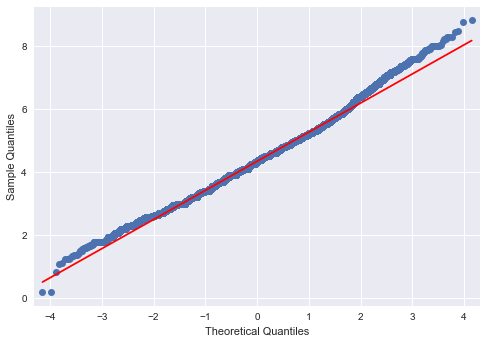

In [113]:
qqplot(X_train['log_price'], line='s')
plt.show()

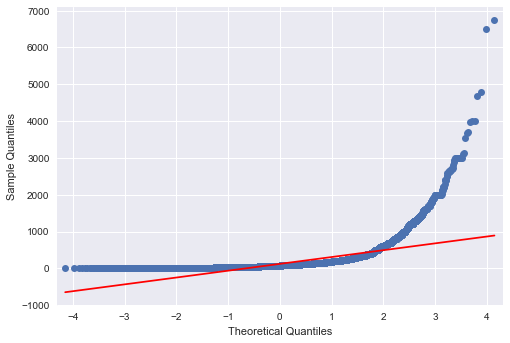

In [114]:
qqplot(X_train['price'], line='s')
plt.show()

Price and demand of the overall dataset is highly skewed. However, we do not remove or transform these outliers because the price elasticity of demand is calculated for each product separately. And I would like to keep the demand and price of products with extreme value for later analysis
However, log transformations of the price and demand variables are utilised in further modeling steps

In [115]:
bc_fitted_feature, bc_fitted_lambda = stats.boxcox(X_train['demand']+1) # Again, we are adding 1 because all features have 0s (not allowed in BC)


In [116]:
bc_fitted_lambda


-9.869431532031772

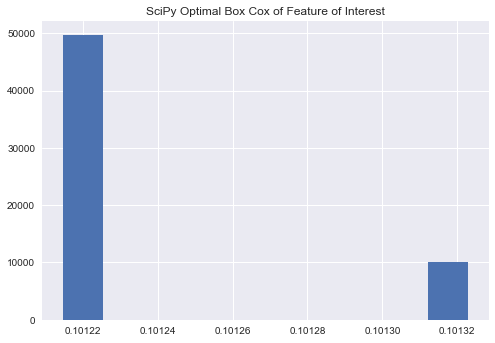

In [117]:
plt.hist(bc_fitted_feature, bins=10)
plt.title('SciPy Optimal Box Cox of Feature of Interest')
plt.show()

In [118]:
X_train['price'].describe()

count    59775.000000
mean       123.431457
std        185.546416
min          1.200000
25%         39.990000
50%         76.900000
75%        139.000000
max       6735.000000
Name: price, dtype: float64

In [119]:
x = X_train[['price']]
factor = 1.5

In [116]:
X_train['order_purchase_timestamp'].max(),X_test['order_purchase_timestamp'].min()

(Timestamp('2018-03-02 00:00:00'), Timestamp('2018-03-02 00:00:00'))

In [123]:
X_train[X_train['product_category_name'] == 'consoles_games']['price'].describe()

count     758.000000
mean      143.531794
std       198.188188
min         5.990000
25%        24.500000
50%        59.990000
75%       155.990000
max      1609.900000
Name: price, dtype: float64

In [124]:
X_train[X_train['product_category_name'] == 'consoles_games']['demand'].describe()

count    758.000000
mean       1.269129
std        0.671261
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        6.000000
Name: demand, dtype: float64

In [125]:
X_train[X_train['product_category_name'] == 'consoles_games']['cumulative_demand'].describe()

count    758.000000
mean       4.746702
std        4.120280
min        1.000000
25%        1.000000
50%        3.000000
75%        7.000000
max       19.000000
Name: cumulative_demand, dtype: float64

In [126]:
IQR = x.quantile(0.75) - x.quantile(0.25) 

# Define upper/lower bound
upper = x.quantile(0.75) + factor*IQR
lower = x.quantile(0.25) - factor*IQR

In [127]:
upper,lower

(price    287.515
 dtype: float64,
 price   -108.525
 dtype: float64)

In [125]:
numerical_cols = product_charateristics_df.select_dtypes(include=['float64','int64']).columns


In [126]:
df_melted = pd.melt(product_charateristics_df[numerical_cols])

In [127]:
product_charateristics_df[numerical_cols].describe()

,demand,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category_frequency,category_mean_price,unique_prod_cats_in_cluster
count,99625.000000,99625.000000,99625.000000,99625.000000,99625.000000,99625.000000,99625.000000,99625.000000,99625.000000,99625.000000,99625.000000,99625.000000,39.000000
mean,1.286263,125.020872,20.222854,48.890752,788.731049,2.237860,2098.860746,30.133161,16.436045,23.042215,0.052095,125.151935,40.512821
std,0.907805,190.367700,15.998507,9.936763,647.777638,1.731131,3776.165289,16.162861,13.381682,11.779891,0.029697,62.841307,17.465563
min,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,0.000020,28.452917,5.000000
25%,1.000000,39.990000,13.210000,43.000000,350.000000,1.000000,300.000000,18.000000,8.000000,15.000000,0.029534,94.725023,27.500000
50%,1.000000,78.500000,16.360000,52.000000,612.000000,2.000000,683.000000,25.000000,13.000000,20.000000,0.055118,118.589001,42.000000
75%,1.000000,139.400000,21.320000,57.000000,982.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,0.079073,135.395087,53.500000
max,25.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,0.100483,1139.870966,68.000000


In [128]:
product_charateristics_df['product_weight_g']=product_charateristics_df['product_weight_g']/1000

C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


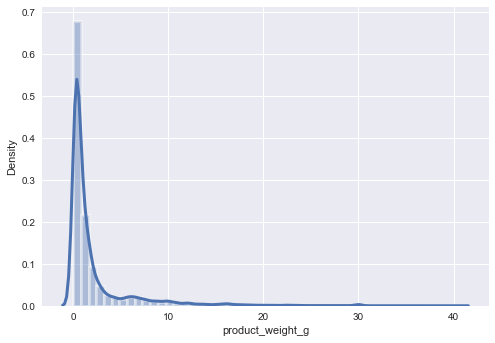

In [129]:
ax = sns.distplot(product_charateristics_df.product_weight_g, hist=True, hist_kws={"edgecolor": 'w', "linewidth": 3}, kde_kws={"linewidth": 3})


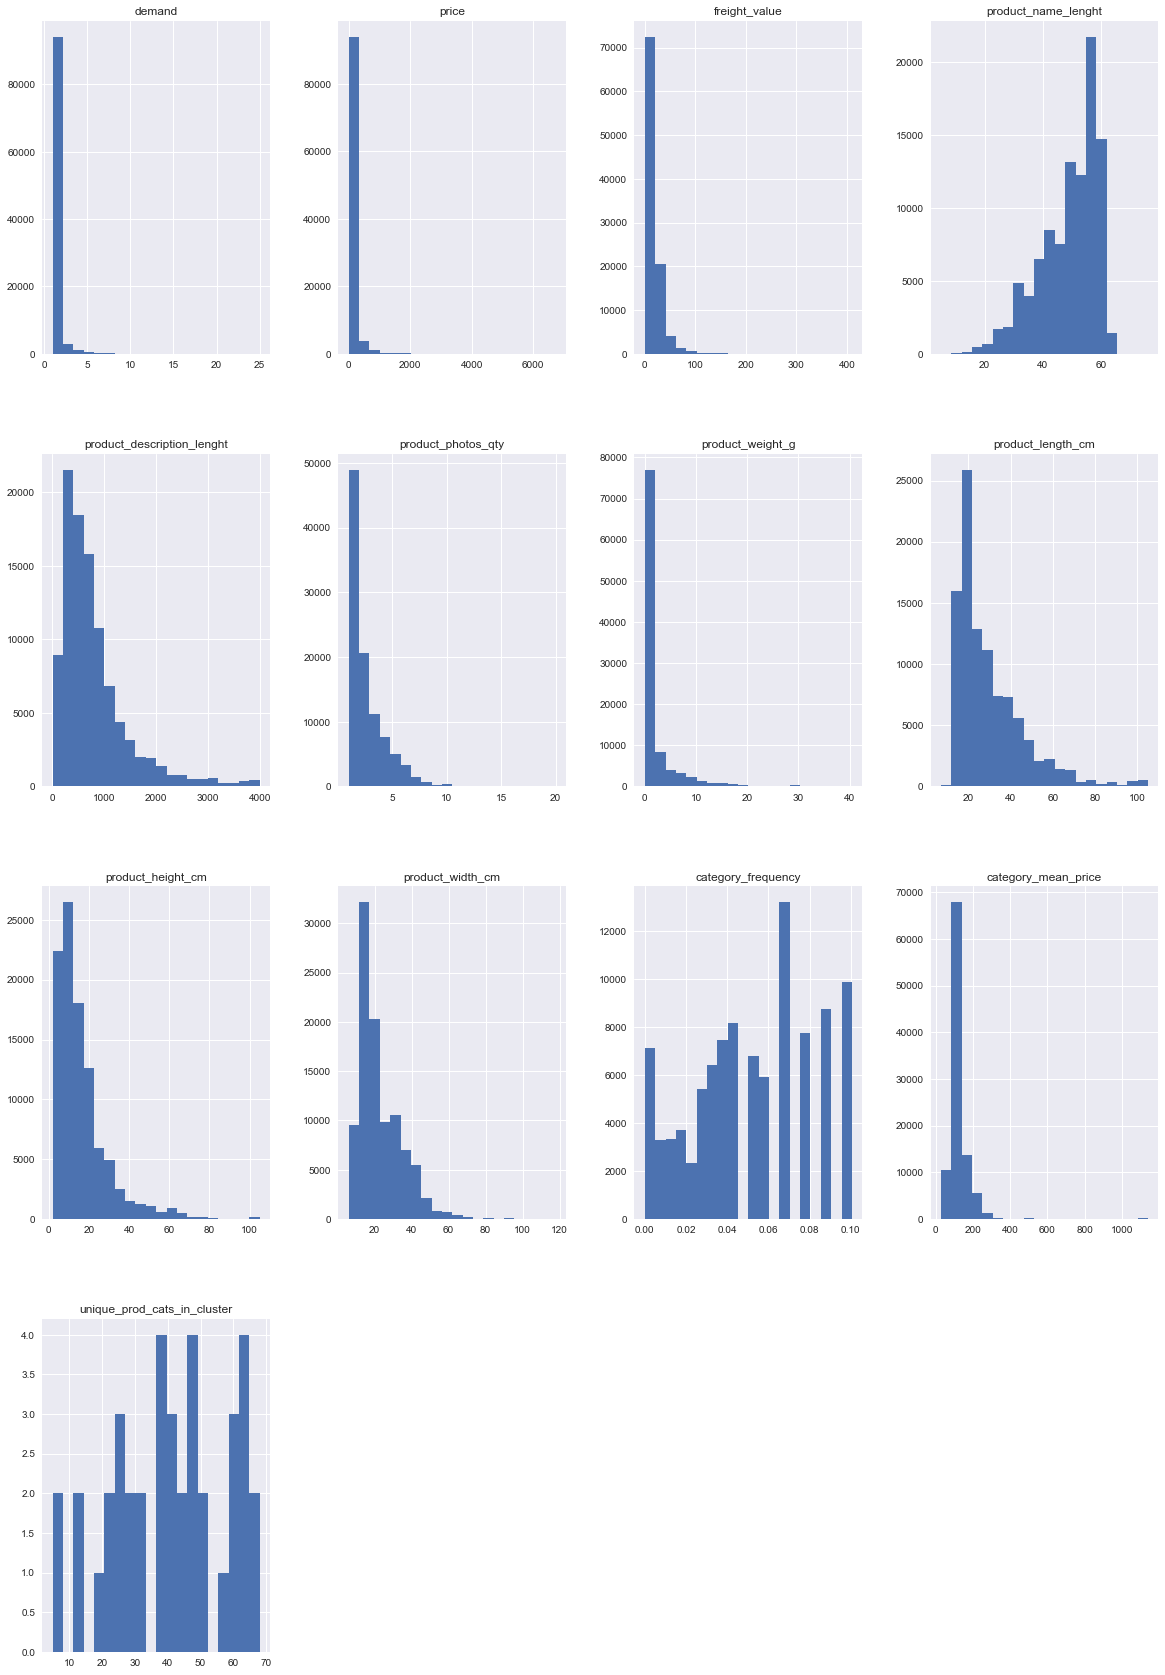

In [138]:
plt.rcParams["figure.figsize"] = (20,30)

#plt.figure(figsize=(20,30))  # enlarge the figure
# We create one histogram for each numeric variable and illustrate how to set the number of bins
product_charateristics_df.select_dtypes(include=['float64','int64']).hist(bins=20);

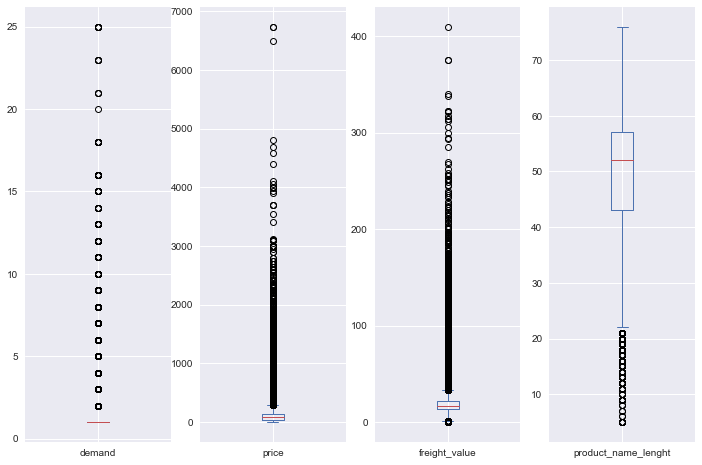

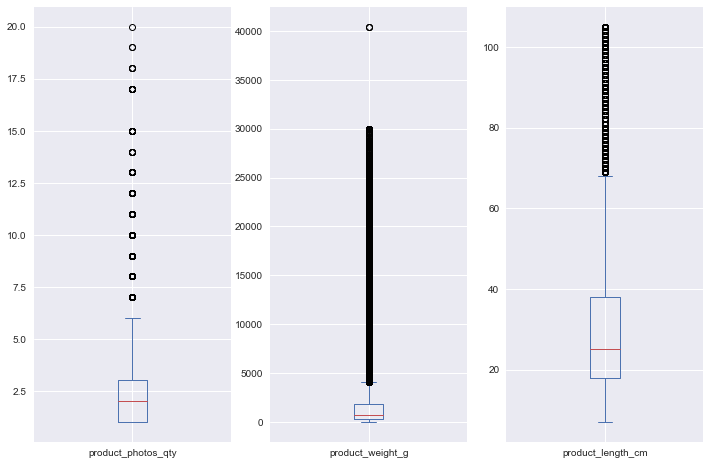

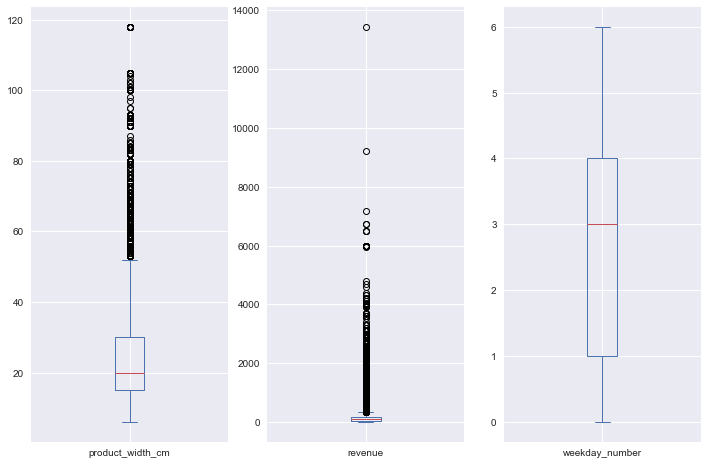

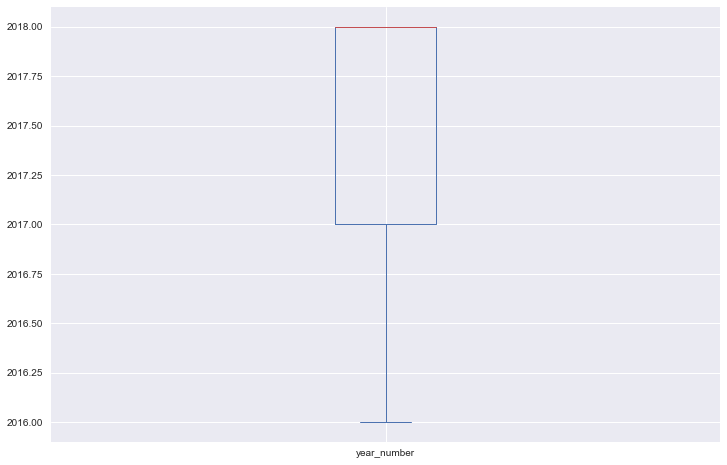

In [135]:

plt.rcParams["figure.figsize"] = (12,8)
num_vars=product_charateristics_df.select_dtypes(include=['float64','int64'])

half = np.ceil(num_vars.shape[1] / 4).astype(int)  # for cosmetic reasons we split the plots into two rows
num_vars.iloc[:, 0:half].plot(kind = 'box', subplots=True);
num_vars.iloc[:, 5:8].plot(kind = 'box', subplots=True);
num_vars.iloc[:, 9:12].plot(kind = 'box', subplots=True);
num_vars.iloc[:, 13:num_vars.shape[1]].plot(kind = 'box', subplots=True);


## Standardization

In [136]:
num_cols=[
 'price',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'cumulative_demand',
]

In [137]:
for col in num_cols:
    X_test["standardized_"+col] = X_test[col]
    X_train["standardized_"+col] = X_train[col]

In [138]:
standardscaler = StandardScaler()
train_standardscaled=X_train[num_cols]
test_standardscaled=X_test[num_cols]


In [139]:
cols = ['standardized_price',
       'standardized_product_name_lenght',
       'standardized_product_description_lenght',
       'standardized_product_photos_qty', 'standardized_product_weight_g',
       'standardized_product_length_cm', 'standardized_product_height_cm',
       'standardized_product_width_cm', 'standardized_cumulative_demand']

In [140]:
#for col in num_cols for train df:
X_train[cols] = standardscaler.fit_transform(X_train[num_cols])
#for col in num_cols for test:
X_test[cols] = standardscaler.fit_transform(X_test[num_cols])

In [141]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39850 entries, 0 to 39849
Data columns (total 40 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   product_id                               39850 non-null  object        
 1   order_purchase_timestamp                 39850 non-null  datetime64[ns]
 2   demand                                   39850 non-null  int64         
 3   price                                    39850 non-null  float64       
 4   freight_value                            39850 non-null  float64       
 5   product_category_name                    39850 non-null  object        
 6   product_name_lenght                      39850 non-null  float64       
 7   product_description_lenght               39850 non-null  float64       
 8   product_photos_qty                       39850 non-null  float64       
 9   product_weight_g                       

# Dynamic pricing

## Price Elasticity of Demand

From the demand prediction model, one determines the forecast of the quantity of a specific product demanded at a base price for the next few days. However, to find the optimal price for a product that maximizes revenue, one needs to estimate demand at different points. To estimate potential demand at varying price levels, the model incorporates the principle of price elasticity of demand, which quantifies how sensitive the demand is to changes in its price.

In [147]:
X_train['price_count'] = X_train.groupby('product_id')['price'].transform('nunique')

In [148]:
X_train.columns

Index(['product_id', 'order_purchase_timestamp', 'demand', 'price',
       'freight_value', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm', 'cluster',
       'category_frequency', 'category_mean_demand', 'avg_price_last_3_days',
       'cumulative_demand', 'revenue', 'weekday_name', 'weekday_number',
       'month_number', 'month_name', 'year_number', 'week_year', 'week_number',
       'is_holiday', 'sales_margin', 'log_price', 'log_revenue', 'log_demand',
       'standardized_price', 'standardized_product_name_lenght',
       'standardized_product_description_lenght',
       'standardized_product_photos_qty', 'standardized_product_weight_g',
       'standardized_product_length_cm', 'standardized_product_height_cm',
       'standardized_product_width_cm', 'standardized_cumulative_demand',
       'price_count'],
      dtype='object')

In [149]:
X_train_PED = X_train[X_train['price_count'] > 1]

In [150]:
X_train_PED.shape,X_train.shape

((26280, 41), (59775, 41))

In [151]:
X_train_PED['product_id'].nunique()/X_train['product_id'].nunique()*100

15.395846088635615

In [152]:
X_train_PED.shape[0]/X_train['product_id'].shape[0]*100

43.96486825595985

In [153]:
common_product_id = set(X_train_PED['product_id'].unique()).intersection(set(X_train[X_train['price_count'] < 1]['product_id'].unique()))
common_product_id

set()

In [154]:
X_train_PED.product_id.nunique(),X_train.product_id.nunique()

(3269, 21233)

In [155]:
def linear_reg(data,explanatory_vars,target_var):
    linear_regressor = LinearRegression()  # create object for the class
    #x = data.drop(['product_id','demand','freight_value','cumulative_demand'], axis=1)
    x=data[explanatory_vars]
    y = data[target_var]
    if data.shape[0] > 1:
        linear_regressor.fit(x,y)  # perform linear regression
        yhat = linear_regressor.predict(x)  # make predictions
        mae = metrics.mean_absolute_error(y, yhat)
        mse = metrics.mean_squared_error(y, yhat)
        rmse = np.sqrt(mse) # or mse**(0.5)  
        r2 = metrics.r2_score(y,yhat)
        data['intercept'] = linear_regressor.intercept_
        data['mae'] = mae
        data['mse'] = mse
        data['rmse'] = rmse
        data['r2'] = r2        
        for i, feature in enumerate(x.columns):
            coef_column_name = f'coef_{feature}'
            data[coef_column_name] = linear_regressor.coef_[i]
    else:
        data['intercept'] = -99999
        for i, feature in enumerate(x.columns):
            coef_column_name = f'coef_{feature}'
            data[coef_column_name] =-99999
    return data
#     data['feature1_coeff'] = model.coef_[0]
#     data['feature2_coeff'] = model.coef_[1]

In [156]:
#linear model
X_train_PED_linear = X_train_PED
X_train_PED_linear = X_train_PED_linear.groupby('product_id').apply(linear_reg,explanatory_vars=['price'],target_var='demand')

In [157]:
## log-log model
X_train_PED_log = X_train_PED.copy()
X_train_PED_log = X_train_PED_log.groupby('product_id').apply(linear_reg,explanatory_vars=['log_price'],target_var='log_demand')

In [158]:
#log-linear model
X_train_PED_log_linear = X_train_PED.copy()
X_train_PED_log_linear = X_train_PED_log.groupby('product_id').apply(linear_reg,explanatory_vars=['log_price'],target_var='demand')

In [159]:
X_train_PED_linear[['mae','mse','rmse','r2','coef_price']].describe()

,mae,mse,rmse,r2,coef_price
count,26280.000000,26280.000000,26280.000000,2.628000e+04,2.628000e+04
mean,0.422724,0.907102,0.575977,3.979756e-01,3.678901e-02
std,0.522207,2.508323,0.758534,4.372891e-01,2.743451e+00
min,0.000000,0.000000,0.000000,-4.440892e-16,-7.142857e+01
25%,0.000000,0.000000,0.000000,2.739285e-02,-2.381845e-02
50%,0.281942,0.140135,0.374347,1.356246e-01,0.000000e+00
75%,0.609524,0.564464,0.751309,1.000000e+00,5.624359e-19
max,2.794865,20.282074,4.503562,1.000000e+00,1.000000e+02


In [160]:
X_train_PED_log[['mae','mse','rmse','r2','coef_log_price']].describe().to_csv('PED_Performance_correct.csv')

In [161]:
X_train_PED_log_linear[['mae','mse','rmse','r2','coef_log_price']].describe()

,mae,mse,rmse,r2,coef_log_price
count,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000
mean,0.422193,0.905246,0.575521,0.398572,3.273625
std,0.521462,2.501081,0.757656,0.437084,320.017530
min,0.000000,0.000000,0.000000,0.000000,-6713.928565
25%,0.000000,0.000000,0.000000,0.026659,-2.186877
50%,0.281728,0.140450,0.374767,0.135419,0.000000
75%,0.609688,0.560959,0.748972,1.000000,0.059929
max,2.789245,20.205333,4.495034,1.000000,18998.499996


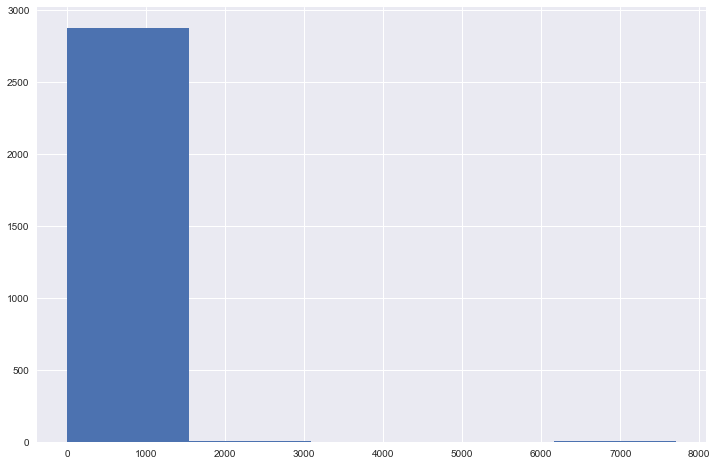

In [162]:
plt.hist(X_train_PED_log[X_train_PED_log['coef_log_price'] >1 ]['coef_log_price'],bins = 5)
plt.show()

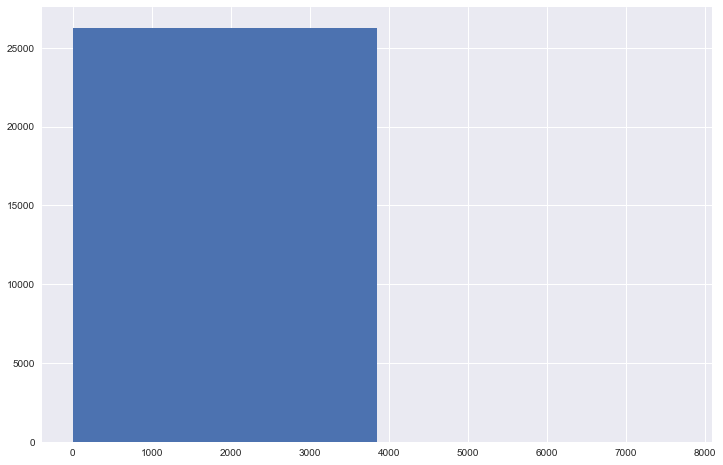

In [163]:
abs_PED = X_train_PED_log.copy()
abs_PED['abs_coef_price'] = abs(abs_PED['coef_log_price'])
plt.hist(abs_PED['abs_coef_price'],bins = 2)
plt.show()

In [164]:
abs_PED[['abs_coef_price','coef_log_price']]

,abs_coef_price,coef_log_price
0,2.033949,-2.033949
3,3.453457,-3.453457
8,0.000000,0.000000
11,0.178812,-0.178812
13,0.000000,0.000000
...,...,...
59756,1.440454,-1.440454
59760,0.000000,0.000000
59769,0.258163,0.258163
59770,0.490943,-0.490943


In [165]:
abs_PED[abs_PED['abs_coef_price'] >1 ]['product_id'].nunique()/abs_PED['product_id'].nunique()*100 

20.893239522789845

In [166]:
abs_PED[abs_PED['abs_coef_price'] <1]['product_id'].nunique()/abs_PED['product_id'].nunique()*100 

79.10676047721016

79% products are inelastic

In [167]:
X_train_PED_log[X_train_PED_log['coef_log_price'] < -500].shape

(17, 47)

In [168]:
X_train_PED_log.query('coef_log_price > -500 and coef_log_price < 0')['product_category_name'].unique()

array(['moveis_decoracao', 'beleza_saude', 'esporte_lazer',
       'moveis_escritorio', 'informatica_acessorios', 'perfumaria',
       'utilidades_domesticas', 'brinquedos', 'telefonia_fixa',
       'telefonia', 'market_place', 'eletronicos',
       'fashion_bolsas_e_acessorios', 'cama_mesa_banho',
       'agro_industria_e_comercio', 'ferramentas_jardim', 'cool_stuff',
       'automotivo', 'malas_acessorios', 'bebes', 'pet_shop',
       'moveis_sala', 'consoles_games', 'eletrodomesticos_2',
       'eletroportateis', 'tablets_impressao_imagem',
       'relogios_presentes', 'miscellaneous', 'moveis_quarto',
       'eletrodomesticos', 'climatizacao', 'fashion_calcados',
       'livros_interesse_geral', 'audio', 'papelaria',
       'instrumentos_musicais',
       'moveis_cozinha_area_de_servico_jantar_e_jardim',
       'construcao_ferramentas_jardim',
       'construcao_ferramentas_construcao', 'cds_dvds_musicais',
       'construcao_ferramentas_iluminacao', 'alimentos_bebidas', 'pcs',
   

In [170]:
X_train_PED_log.cluster.nunique()

14

(array([  3.,   0.,   0.,   2., 127.]),
 array([-118.4902215 ,  -92.17024291,  -65.85026433,  -39.53028574,
         -13.21030716,   13.10967143]),
 <BarContainer object of 5 artists>)

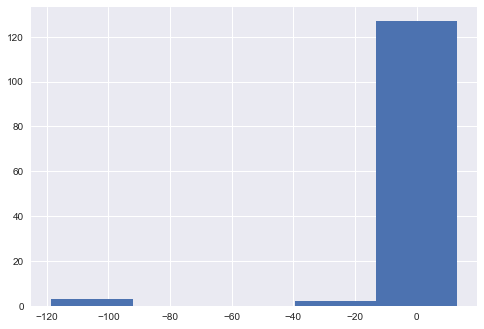

In [149]:
plt.hist(X_train_PED_log[X_train_PED_log['cluster'] == 4]['coef_log_price'],bins = 5)


1. find articles which have a coef_price for both X_test and X_train (because X_train only contains prods with unique price points)
2. for these artciles extract coef_price from the dataset used for running PED
3. map the artciles in X_test and X_train with coef_price

In [171]:
articles_with_history = X_test[X_test['product_id'].isin(X_train_PED_log['product_id'])]['product_id'].unique()

In [172]:
 len(articles_with_history)/X_test.product_id.nunique() * 100 # 8% of articles in test dataset will be directly mapped to the estimated PED

8.16729492012206

In [174]:
X_test[X_test['product_id'].isin(X_train_PED_log['product_id'])].shape[0]/X_test.shape[0]*100

21.397741530740277

In [175]:
X_test.shape[0]

39850

In [176]:
X_test.product_id.nunique()

16713

In [177]:
#mapping PED on cluster level, i.e product similarity level
matched_records_df_for_train_df = X_train_PED_log[['product_id','coef_log_price']].drop_duplicates()

In [178]:
matched_records_df_for_train_df

,product_id,coef_log_price
0,c1488892604e4ba5cff5b4eb4d595400,-2.033949
3,5a6b04657a4c5ee34285d1e4619a96b4,-3.453457
8,b72b39418216e944bb34e35f4d3ea8c7,0.000000
11,9c7bdf67b06b419aefb93cfdfc96c55d,-0.178812
13,583916a5dae918f5e89baec139141c54,0.000000
...,...,...
56815,ad4b5def91ac7c575dbdf65b5be311f4,0.853677
56916,437c05a395e9e47f9762e677a7068ce7,-3.686743
57039,eb2d12bc991561d4ca5deff0e60854e4,0.000000
57306,52e5fdcb5e51164483d584c75bd3a478,1.708627


In [179]:
X_train_PED_log['cluster'].nunique(),X_train['cluster'].nunique()

(14, 15)

In [180]:
X_train[~X_train['cluster'].isin(X_train_PED_log['cluster'])]['cluster'].unique()

array([2])

In [181]:
X_test[~X_test['cluster'].isin(X_train_PED_log['cluster'])]['cluster'].unique()

array([2])

In [182]:
X_test.query('cluster == 2')['product_id'].nunique()

8

In [183]:
X_train.query('cluster == 2')['product_id'].nunique()

10

In [184]:
X_train.query('cluster == 2').query('price_count == 1')['product_id'].nunique()

10

In [185]:
X_train_new = X_train.query('cluster != 2')
X_test_new = X_test.query('cluster != 2')

In [186]:
X_train_new['product_id'].nunique(),X_train['product_id'].nunique(),X_test['product_id'].nunique(),X_test_new['product_id'].nunique()



(21223, 21233, 16713, 16705)

In [187]:
series_train = matched_records_df_for_train_df.set_index('product_id')['coef_log_price']
series_train

product_id
c1488892604e4ba5cff5b4eb4d595400   -2.033949
5a6b04657a4c5ee34285d1e4619a96b4   -3.453457
b72b39418216e944bb34e35f4d3ea8c7    0.000000
9c7bdf67b06b419aefb93cfdfc96c55d   -0.178812
583916a5dae918f5e89baec139141c54    0.000000
                                      ...   
ad4b5def91ac7c575dbdf65b5be311f4    0.853677
437c05a395e9e47f9762e677a7068ce7   -3.686743
eb2d12bc991561d4ca5deff0e60854e4    0.000000
52e5fdcb5e51164483d584c75bd3a478    1.708627
a3dae37f1227e4037d5e3be3f228bc84    0.000000
Name: coef_log_price, Length: 3269, dtype: float64

In [188]:
X_train_new['coef_log_price'] = X_train_new['product_id'].map(series_train)

C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\1919948048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_new['coef_log_price'] = X_train_new['product_id'].map(series_train)


In [189]:
X_test_new['coef_log_price'] = X_test_new['product_id'].map(series_train)

C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\1957266858.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_new['coef_log_price'] = X_test_new['product_id'].map(series_train)


In [190]:
X_test_new[X_test_new['coef_log_price'].isnull()]['product_id'].nunique()

15340

In [191]:
X_test_new['coef_log_price'].notnull().sum()

8527

In [192]:
X_test_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39842 entries, 0 to 39849
Data columns (total 41 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   product_id                               39842 non-null  object        
 1   order_purchase_timestamp                 39842 non-null  datetime64[ns]
 2   demand                                   39842 non-null  int64         
 3   price                                    39842 non-null  float64       
 4   freight_value                            39842 non-null  float64       
 5   product_category_name                    39842 non-null  object        
 6   product_name_lenght                      39842 non-null  float64       
 7   product_description_lenght               39842 non-null  float64       
 8   product_photos_qty                       39842 non-null  float64       
 9   product_weight_g                       

In [193]:
coef_price_mean_every_cluster=X_train_PED_log.groupby('cluster')['coef_log_price'].mean()

In [194]:
coef_price_mean_every_cluster

cluster
0     -0.032212
1      0.000000
3      0.002417
4     -0.344878
5      0.853677
6     -0.599550
7      1.737454
8      2.065511
9      0.071634
10     0.354513
11    16.540314
12    -0.357141
13    -1.432850
14     0.669254
Name: coef_log_price, dtype: float64

In [195]:
X_test_new['coef_log_price'] = X_test_new.apply(
        lambda row: coef_price_mean_every_cluster[row['cluster']] if pd.isna(row['coef_log_price']) else row['coef_log_price'], 
        axis=1
    )

C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\3969455632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_new['coef_log_price'] = X_test_new.apply(


In [196]:
X_train_new['coef_log_price'] = X_train_new.apply(
        lambda row: coef_price_mean_every_cluster[row['cluster']] if pd.isna(row['coef_log_price']) else row['coef_log_price'], 
        axis=1
    )

C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\1800649942.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_new['coef_log_price'] = X_train_new.apply(


In [197]:
X_train_new.isnull().sum()

product_id                                 0
order_purchase_timestamp                   0
demand                                     0
price                                      0
freight_value                              0
product_category_name                      0
product_name_lenght                        0
product_description_lenght                 0
product_photos_qty                         0
product_weight_g                           0
product_length_cm                          0
product_height_cm                          0
product_width_cm                           0
cluster                                    0
category_frequency                         0
category_mean_demand                       0
avg_price_last_3_days                      0
cumulative_demand                          0
revenue                                    0
weekday_name                               0
weekday_number                             0
month_number                               0
month_name

In [198]:
X_test_new.isnull().sum()

product_id                                 0
order_purchase_timestamp                   0
demand                                     0
price                                      0
freight_value                              0
product_category_name                      0
product_name_lenght                        0
product_description_lenght                 0
product_photos_qty                         0
product_weight_g                           0
product_length_cm                          0
product_height_cm                          0
product_width_cm                           0
cluster                                    0
category_frequency                         0
category_mean_demand                       0
avg_price_last_3_days                      0
cumulative_demand                          0
revenue                                    0
weekday_name                               0
weekday_number                             0
month_number                               0
month_name

In [199]:
X_train_new['coef_log_price'].describe()

count    59765.000000
mean         1.688487
std         81.088104
min      -2161.130235
25%          0.000000
50%          0.002417
75%          0.669254
max       7703.228855
Name: coef_log_price, dtype: float64

## Demand Forecasting Model

In this segment, the model for predicting demand is presented.

In [200]:
X_train_new.select_dtypes(include=['float64','int64']).columns

Index(['demand', 'price', 'freight_value', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'category_frequency', 'category_mean_demand', 'avg_price_last_3_days',
       'cumulative_demand', 'revenue', 'weekday_number', 'month_number',
       'year_number', 'sales_margin', 'log_price', 'log_revenue', 'log_demand',
       'standardized_price', 'standardized_product_name_lenght',
       'standardized_product_description_lenght',
       'standardized_product_photos_qty', 'standardized_product_weight_g',
       'standardized_product_length_cm', 'standardized_product_height_cm',
       'standardized_product_width_cm', 'standardized_cumulative_demand',
       'price_count', 'coef_log_price'],
      dtype='object')

### Feature Selection for Demand forecasting model

#### Filter Method

For the feature selection process for Demand prediction, first Filters are used, like correlation. These are statistical techniques that evaluate variables individually and test their significance or relationship with other variables. Due to their computational simplicity, they are often the initial methods employed in the analysis process

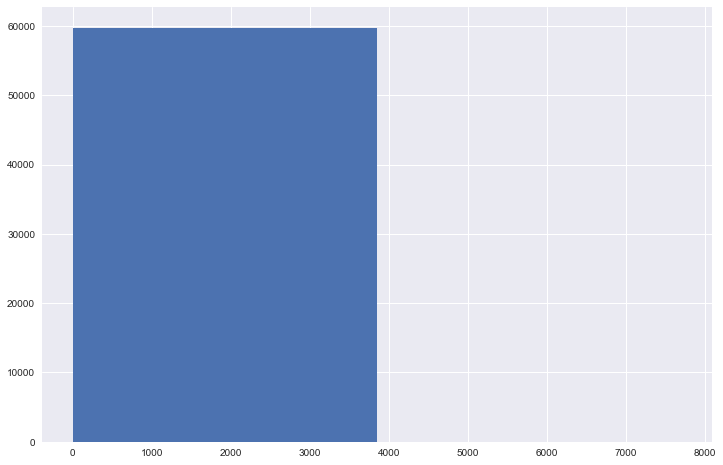

In [203]:
abs_PED = X_train_new.copy()
abs_PED['abs_coef_price'] = abs(abs_PED['coef_log_price'])
plt.hist(abs_PED['abs_coef_price'],bins = 2)
plt.show()

In [204]:
abs_PED[abs_PED['abs_coef_price'] < 1 ]['product_id'].nunique()/abs_PED['product_id'].nunique()*100 

77.62333317627103

In [205]:
abs_PED[abs_PED['abs_coef_price'] < 1 ]['is_holiday'].sum()/abs_PED[abs_PED['abs_coef_price'] < 1 ].shape[0]

0.2529456433873062

In [206]:
abs_PED.shape[0]

59765

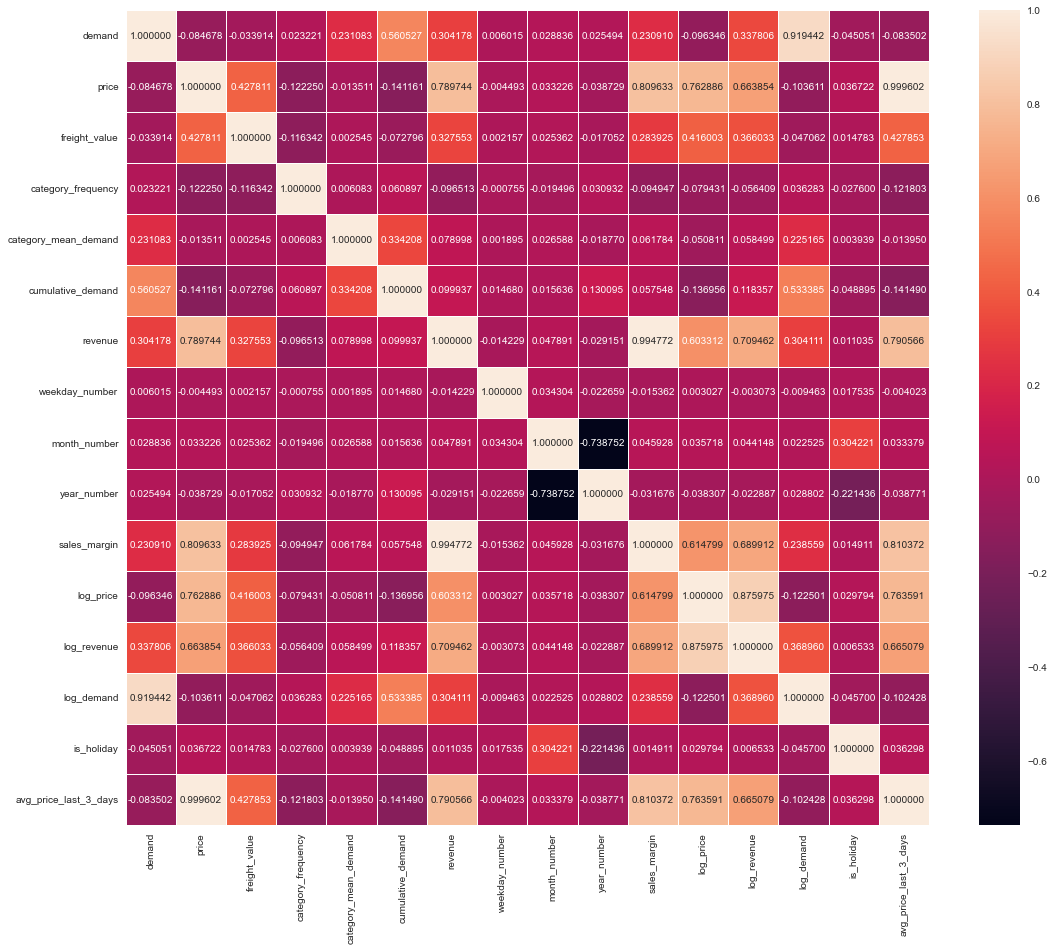

In [207]:
corr = abs_PED[abs_PED['abs_coef_price'] >1 ][['demand', 'price', 'freight_value','category_frequency', 'category_mean_demand','cumulative_demand', 'revenue',
       'weekday_number', 'month_number', 'year_number', 'sales_margin',
       'log_price', 'log_revenue', 'log_demand','is_holiday','avg_price_last_3_days']].corr()
f,ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr ,annot=True,linewidth=.5,fmt='1f');

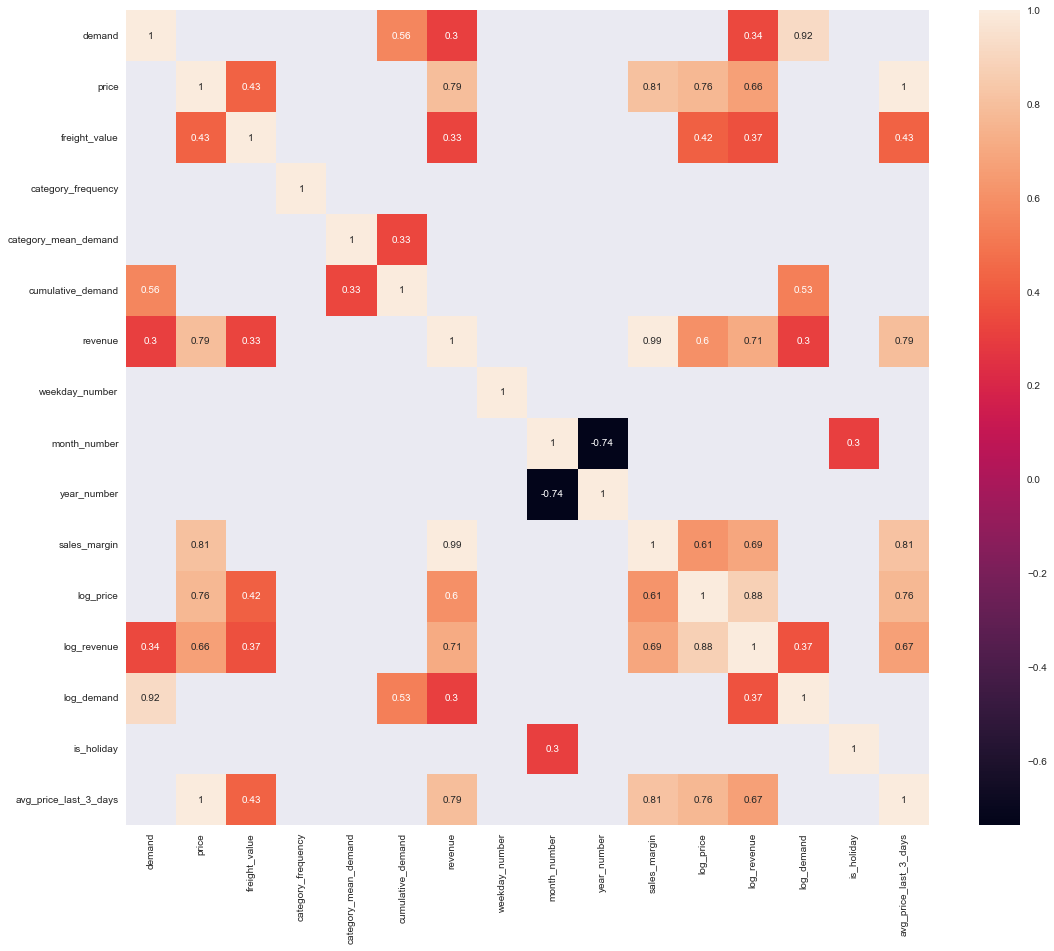

In [208]:
f,ax = plt.subplots(figsize=(18, 15))

sns.heatmap(corr[(corr >= 0.30) | (corr <= -0.30)],
            annot=True);

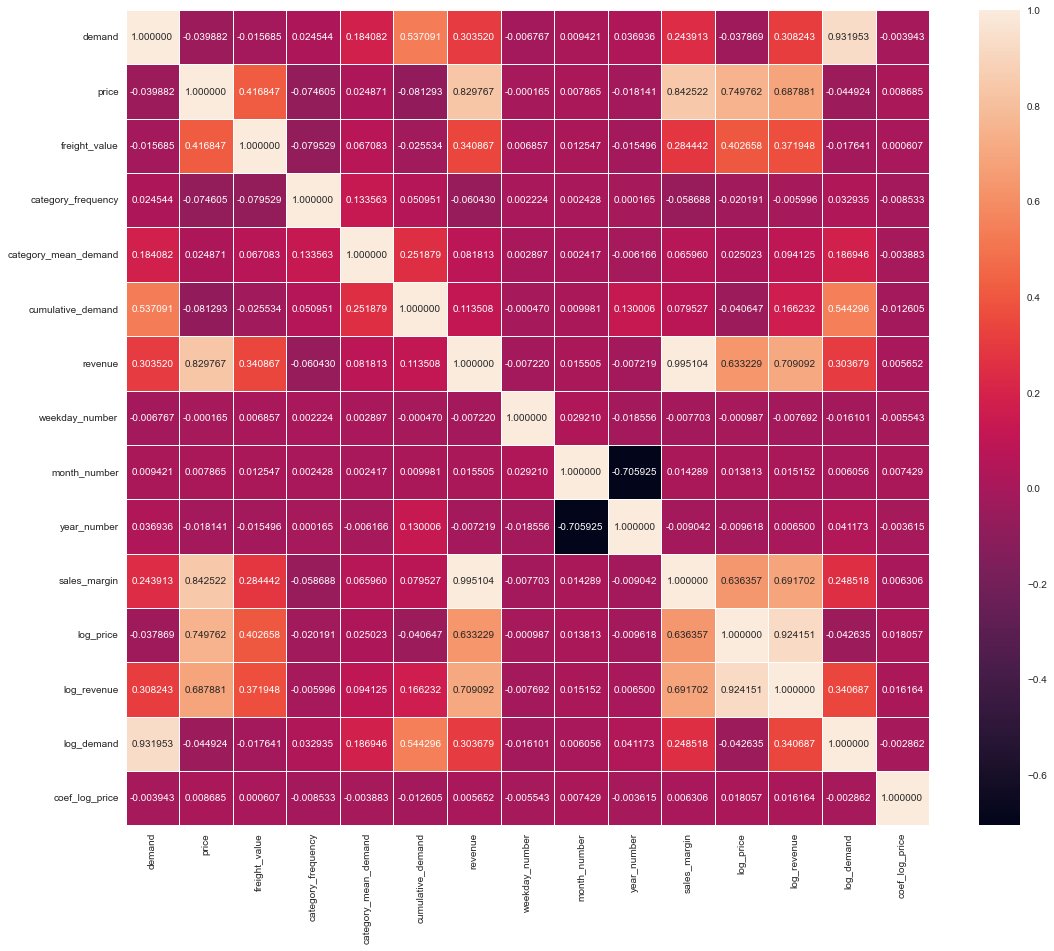

In [209]:
corr = X_train_new[['demand', 'price', 'freight_value','category_frequency', 'category_mean_demand','cumulative_demand', 'revenue',
       'weekday_number', 'month_number', 'year_number', 'sales_margin',
       'log_price', 'log_revenue', 'log_demand','coef_log_price']].corr()
f,ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr ,annot=True,linewidth=.5,fmt='1f');

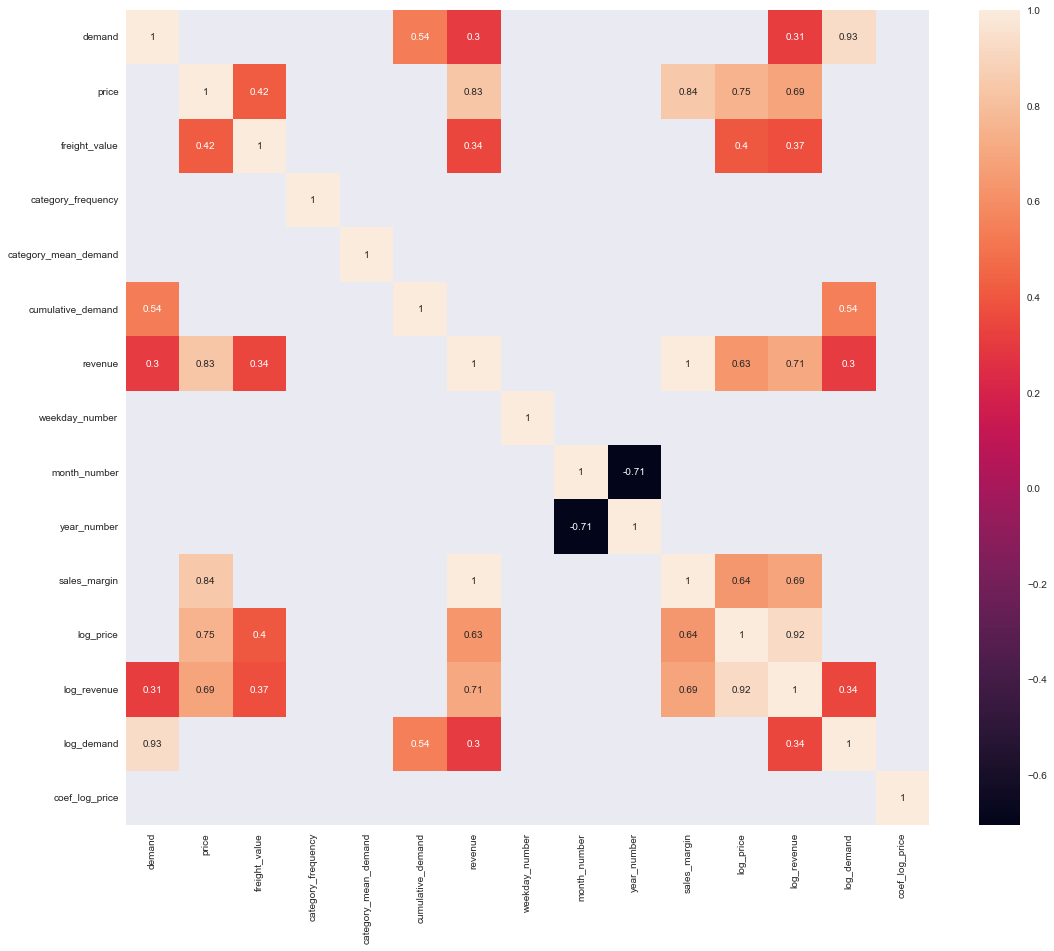

In [210]:
f,ax = plt.subplots(figsize=(18, 15))

sns.heatmap(corr[(corr >= 0.30) | (corr <= -0.30)],
            annot=True);

In [211]:
X_train_RF = X_train_new[['product_id','order_purchase_timestamp','demand', 'price', 'freight_value','category_frequency','cumulative_demand', 'revenue',
       'weekday_number', 'month_number', 'year_number', 'is_holiday','sales_margin',
       'log_price','coef_log_price','avg_price_last_3_days','category_mean_demand','product_category_name']]
# X_train_RF.set_index('order_purchase_timestamp', inplace=True)
# X_train_RF.sort_index(inplace=True)

In [212]:
X_test_RF = X_test_new[['product_id','order_purchase_timestamp','demand', 'price', 'freight_value','category_frequency','cumulative_demand', 'revenue',
       'weekday_number', 'month_number', 'year_number','is_holiday','sales_margin',
       'log_price', 'coef_log_price','avg_price_last_3_days','category_mean_demand','product_category_name']]
# X_test_RF.set_index('order_purchase_timestamp', inplace=True)
# X_test_RF.sort_index(inplace=True)

In [213]:
X_test_RF.shape,X_train_RF.shape

((39842, 18), (59765, 18))

In [214]:
y_train = X_train_RF[['demand']]

In [215]:
X_train_RF.shape,y_train.shape

((59765, 18), (59765, 1))

In [216]:
y_train

,demand
0,1
1,1
2,1
3,3
4,1
...,...
59770,1
59771,1
59772,1
59773,1


In [195]:
len(np.ravel(y_train.values))

59765

#### Wrapper Method

However, to select features that fit the model, the study employs the Wrapper method to select features. Wrappers try to iteratively build models in different ways to detect variables that have the highest positive impact on a model's performance. This allows for the identification of feature interactions that filter methods may miss. This paper adopts Stepwise regression (Forward regression) that adds removes one feature at a time based on model performance until a feature subset of the desired size k is reached. 

In [217]:
!pip install mlxtend


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [171]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
sfs = SFS(rf, 
           k_features=(6,11), 
           forward=True, 
           floating=False, 
           scoring='neg_mean_absolute_error',
           cv=3)

sfs = sfs.fit(X_train_RF.drop(['product_id','demand','coef_log_price','order_purchase_timestamp','revenue','sales_margin'],axis=1), np.ravel(y_train.values))

In [172]:
sfs

SequentialFeatureSelector(cv=3,
                          estimator=RandomForestRegressor(random_state=42),
                          k_features=(6, 11),
                          scoring='neg_mean_absolute_error')

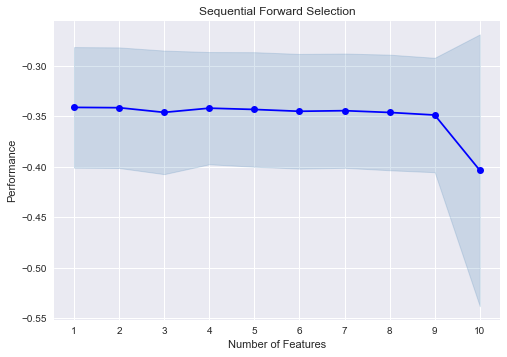

In [287]:

plot_sfs(sfs.get_metric_dict())
plt.title('Sequential Forward Selection')

plt.show()

In [176]:
print('best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_names_))

best combination (ACC: -0.345): ('price', 'cumulative_demand', 'weekday_number', 'is_holiday', 'log_price', 'avg_price_last_3_days', 'category_mean_demand')



### Model Selection for Demand Forecasting model

In [218]:
y_test = X_test_RF[['demand']]

In [219]:
X_train_RF.columns

Index(['product_id', 'order_purchase_timestamp', 'demand', 'price',
       'freight_value', 'category_frequency', 'cumulative_demand', 'revenue',
       'weekday_number', 'month_number', 'year_number', 'is_holiday',
       'sales_margin', 'log_price', 'coef_log_price', 'avg_price_last_3_days',
       'category_mean_demand', 'product_category_name'],
      dtype='object')

#### Random Forest

##### Testing with only past demand

In [225]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_RF[['cumulative_demand']], y_train)

# Evaluate the model
y_pred = rf.predict(X_test_RF[['cumulative_demand']])
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error:", mae)

C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\2619313023.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_RF[['cumulative_demand']], y_train)


Mean absolute error: 0.3167628095472856


##### Testing with all selected variables

In [226]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_RF[['price', 'cumulative_demand', 'weekday_number',
       'is_holiday', 'log_price', 'avg_price_last_3_days',
       'category_mean_demand','month_number']], y_train)

C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\2295865570.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_RF[['price', 'cumulative_demand', 'weekday_number',


RandomForestRegressor(random_state=42)

In [227]:
X_train_RF.drop(['product_id','demand','coef_log_price','order_purchase_timestamp','revenue','sales_margin','category_frequency','year_number','month_number'],axis=1).columns

Index(['price', 'freight_value', 'cumulative_demand', 'weekday_number',
       'is_holiday', 'log_price', 'avg_price_last_3_days',
       'category_mean_demand', 'product_category_name'],
      dtype='object')

In [228]:
# Evaluate the model
y_pred = rf.predict(X_test_RF[['price', 'cumulative_demand', 'weekday_number',
       'is_holiday', 'log_price', 'avg_price_last_3_days',
       'category_mean_demand','month_number']])
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error:", mae)

Mean absolute error: 0.3543143220555248


In [229]:
X_test_RF['est_demand'] = y_pred

C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\889816402.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_RF['est_demand'] = y_pred


#### Linear Regression

##### Testing with only past demand

In [230]:
lin_reg = LinearRegression().fit(X_train_RF[['cumulative_demand']], y_train)
y_pred_lin = lin_reg.predict(X_test_RF[['cumulative_demand']])
mae = mean_absolute_error(y_test, y_pred_lin)
print("Mean absolute error:", mae)

Mean absolute error: 0.3753497354153425


##### Testing with all selected variables

In [231]:
lin_reg = LinearRegression().fit(X_train_RF[['price', 'freight_value', 'cumulative_demand', 'weekday_number',
       'is_holiday', 'log_price', 'avg_price_last_3_days',
       'category_mean_demand','month_number']], y_train)

In [233]:
y_pred_lin = lin_reg.predict(X_test_RF[['price', 'freight_value', 'cumulative_demand', 'weekday_number',
       'is_holiday', 'log_price', 'avg_price_last_3_days',
       'category_mean_demand','month_number']])
mae = mean_absolute_error(y_test, y_pred_lin)
print("Mean absolute error:", mae)

Mean absolute error: 0.3807552740148708


#### Lasso and Ridge Regression

In [234]:
X_lasso_train = X_train_RF
X_lasso_test = X_test_RF

num_cols=[
 'price', 'freight_value', 'cumulative_demand', 'weekday_number',
       'is_holiday', 'avg_price_last_3_days',
       'category_mean_demand','month_number'
]
for col in num_cols:
    X_lasso_train["standardized_"+col] = X_test_RF[col]
    X_lasso_test["standardized_"+col] = X_train_RF[col]

C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\80433665.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_lasso_train["standardized_"+col] = X_test_RF[col]
C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\80433665.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_lasso_test["standardized_"+col] = X_train_RF[col]
C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\80433665.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [235]:
X_lasso_train.columns

Index(['product_id', 'order_purchase_timestamp', 'demand', 'price',
       'freight_value', 'category_frequency', 'cumulative_demand', 'revenue',
       'weekday_number', 'month_number', 'year_number', 'is_holiday',
       'sales_margin', 'log_price', 'coef_log_price', 'avg_price_last_3_days',
       'category_mean_demand', 'product_category_name', 'standardized_price',
       'standardized_freight_value', 'standardized_cumulative_demand',
       'standardized_weekday_number', 'standardized_is_holiday',
       'standardized_avg_price_last_3_days',
       'standardized_category_mean_demand', 'standardized_month_number'],
      dtype='object')

In [236]:
standardscaler = StandardScaler()
X_lasso_train=X_train_RF[num_cols]
X_lasso_test=X_test_RF[num_cols]

In [237]:
X_lasso_train.columns

Index(['price', 'freight_value', 'cumulative_demand', 'weekday_number',
       'is_holiday', 'avg_price_last_3_days', 'category_mean_demand',
       'month_number'],
      dtype='object')

In [238]:
cols = ['standardized_price',
       'standardized_freight_value', 'standardized_cumulative_demand',
       'standardized_weekday_number', 'standardized_is_holiday', 'standardized_avg_price_last_3_days',
       'standardized_category_mean_demand', 'standardized_month_number']


In [239]:
#for col in num_cols for train df:
X_lasso_train[cols] = standardscaler.fit_transform(X_lasso_train[num_cols])
#for col in num_cols for test:


C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\147929283.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_lasso_train[cols] = standardscaler.fit_transform(X_lasso_train[num_cols])
C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\147929283.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_lasso_train[cols] = standardscaler.fit_transform(X_lasso_train[num_cols])
C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\147929283.py:2: SettingWithCopyWarning: 
A value is tryi

In [240]:
X_lasso_test[cols] = standardscaler.fit_transform(X_lasso_test[num_cols])


C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\735150362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_lasso_test[cols] = standardscaler.fit_transform(X_lasso_test[num_cols])
C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\735150362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_lasso_test[cols] = standardscaler.fit_transform(X_lasso_test[num_cols])
C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\735150362.py:1: SettingWithCopyWarning: 
A value is trying t

In [241]:
X_lasso_train

,price,freight_value,cumulative_demand,weekday_number,is_holiday,avg_price_last_3_days,category_mean_demand,month_number,standardized_price,standardized_freight_value,standardized_cumulative_demand,standardized_weekday_number,standardized_is_holiday,standardized_avg_price_last_3_days,standardized_category_mean_demand,standardized_month_number
0,39.99,31.67,1.0,6,True,39.990000,1.426910,9,-0.470219,0.858566,-0.782024,1.643480,1.731452,-0.470176,0.762938,0.665976
1,32.90,31.67,1.0,6,True,32.900000,1.426910,9,-0.510532,0.858566,-0.782024,1.643480,1.731452,-0.510477,0.762938,0.665976
2,59.50,15.56,1.0,0,True,59.500000,1.223269,9,-0.359286,-0.270560,-0.782024,-1.414699,1.731452,-0.359278,-0.396847,0.665976
3,44.99,2.83,3.0,3,False,44.990000,1.309746,9,-0.441789,-1.162786,-0.349308,0.114391,-0.577550,-0.441755,0.095659,0.665976
4,100.00,9.34,1.0,6,False,100.000000,1.120764,10,-0.129005,-0.706510,-0.782024,1.643480,-0.577550,-0.129068,-0.980639,0.924144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59770,23.99,11.85,7.0,4,False,23.990000,1.309746,3,-0.561194,-0.530588,0.516125,0.624087,-0.577550,-0.561124,0.095659,-0.883033
59771,139.99,16.74,1.0,4,False,139.990000,1.200275,3,0.098376,-0.187855,-0.782024,0.624087,-0.577550,0.098243,-0.527803,-0.883033
59772,120.00,12.97,8.0,4,False,118.666667,1.117127,3,-0.015286,-0.452089,0.732483,0.624087,-0.577550,-0.022963,-1.001352,-0.883033
59773,49.00,7.78,7.0,4,False,49.000000,1.258363,3,-0.418989,-0.815848,0.516125,0.624087,-0.577550,-0.418962,-0.196980,-0.883033


In [242]:
def regmodel_param_plot(
    validation_score, train_score, alphas_to_try, chosen_alpha,
    scoring, model_name, test_score = None, filename = None):
    
    plt.figure(figsize = (8,8))
    sns.lineplot(y = validation_score, x = alphas_to_try, 
                 label = 'validation_data')
    sns.lineplot(y = train_score, x = alphas_to_try, 
                 label = 'training_data')
    plt.axvline(x=chosen_alpha, linestyle='--')
    if test_score is not None:
        sns.lineplot(y = test_score, x = alphas_to_try, 
                     label = 'test_data')
    plt.xlabel('alpha_parameter')
    plt.ylabel(scoring)
    plt.title(model_name + ' Regularisation')
    plt.legend()
    if filename is not None:
        plt.savefig(str(filename) + ".png")
    plt.show()

In [243]:
def regmodel_param_test(
    alphas_to_try, X, y, cv, scoring = 'r2', 
    model_name = 'LASSO', X_test = None, y_test = None, 
    draw_plot = False, filename = None):
    
    validation_scores = []
    train_scores = []
    results_list = []
    if X_test is not None:
        test_scores = []
        scorer = get_scorer(scoring)
    else:
        test_scores = None

    for curr_alpha in alphas_to_try:
        
        if model_name == 'LASSO':
            regmodel = Lasso(alpha = curr_alpha)
        elif model_name == 'Ridge':
            regmodel = Ridge(alpha = curr_alpha)
        else:
            return None

        results = cross_validate(
            regmodel, X, y, scoring=scoring, cv=cv, 
            return_train_score = True)

        validation_scores.append(np.mean(results['test_score']))
        train_scores.append(np.mean(results['train_score']))
        results_list.append(results)

        if X_test is not None:
            regmodel.fit(X,y)
            y_pred = regmodel.predict(X_test)
            test_scores.append(scorer(regmodel, X_test, y_test))
    
    chosen_alpha_id = np.argmax(validation_scores)
    chosen_alpha = alphas_to_try[chosen_alpha_id]
    max_validation_score = np.max(validation_scores)
    if X_test is not None:
        test_score_at_chosen_alpha = test_scores[chosen_alpha_id]
    else:
        test_score_at_chosen_alpha = None
        
    if draw_plot:
        regmodel_param_plot(
            validation_scores, train_scores, alphas_to_try, chosen_alpha, 
            scoring, model_name, test_scores, filename)
    
    return chosen_alpha, max_validation_score, test_score_at_chosen_alpha

In [244]:
cv = KFold(n_splits=5, shuffle=True, random_state=888)

In [245]:
lasso_alphas = np.linspace(0, 0.02, 11)


In [246]:
X_train_scaled = X_lasso_train[['standardized_price',
       'standardized_freight_value', 'standardized_cumulative_demand',
       'standardized_weekday_number', 'standardized_is_holiday', 'standardized_avg_price_last_3_days',
       'standardized_category_mean_demand', 'standardized_month_number']]
X_test_scaled = X_lasso_test[['standardized_price',
       'standardized_freight_value', 'standardized_cumulative_demand',
       'standardized_weekday_number', 'standardized_is_holiday', 'standardized_avg_price_last_3_days',
       'standardized_category_mean_demand', 'standardized_month_number']]

##### Testing with only Past Demand

C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.554e+04, tolerance: 4.347e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Rid

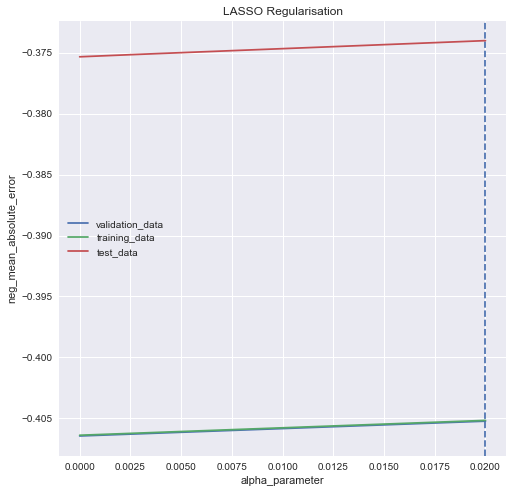

Chosen alpha: 0.02000
Validation score: -0.40522
Test score at chosen alpha: -0.37403


In [247]:
chosen_alpha, max_validation_score, test_score_at_chosen_alpha = \
    regmodel_param_test(
        lasso_alphas, X_lasso_train[['cumulative_demand']], y_train, 
        cv, scoring = 'neg_mean_absolute_error', model_name = 'LASSO', 
        X_test = X_lasso_test[['cumulative_demand']], y_test =y_test, 
        draw_plot = True, filename = 'lasso_wide_search')
print("Chosen alpha: %.5f" % \
    chosen_alpha)
print("Validation score: %.5f" % \
    max_validation_score)
print("Test score at chosen alpha: %.5f" % \
    test_score_at_chosen_alpha)

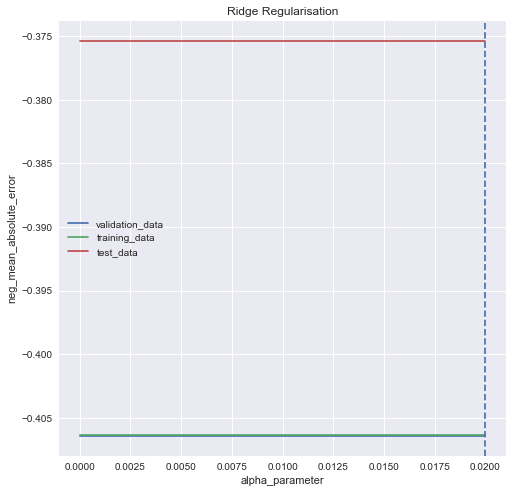

Chosen alpha: 0.02000
Validation score: -0.40644
Test score at chosen alpha: -0.37535


In [248]:
chosen_alpha, max_validation_score, test_score_at_chosen_alpha = \
    regmodel_param_test(
        lasso_alphas, X_lasso_train[['cumulative_demand']], y_train, 
        cv, scoring = 'neg_mean_absolute_error', model_name = 'Ridge', 
        X_test = X_lasso_test[['cumulative_demand']], y_test =y_test, 
        draw_plot = True, filename = 'lasso_wide_search')
print("Chosen alpha: %.5f" % \
    chosen_alpha)
print("Validation score: %.5f" % \
    max_validation_score)
print("Test score at chosen alpha: %.5f" % \
    test_score_at_chosen_alpha)

##### Testing with all selected variables

C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.547e+04, tolerance: 4.347e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Rid

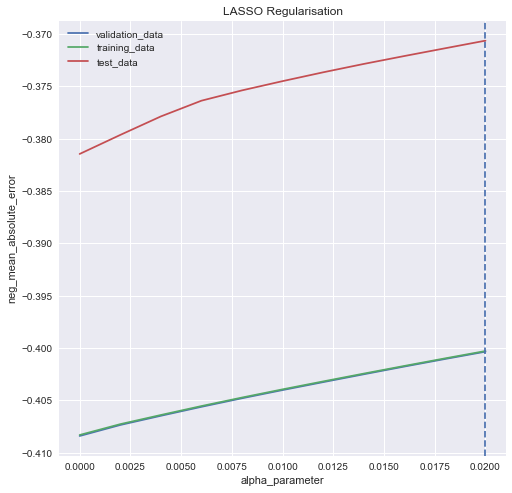

Chosen alpha: 0.02000
Validation score: -0.40035
Test score at chosen alpha: -0.37064


In [250]:
chosen_alpha, max_validation_score, test_score_at_chosen_alpha = \
    regmodel_param_test(
        lasso_alphas, X_train_scaled, y_train, 
        cv, scoring = 'neg_mean_absolute_error', model_name = 'LASSO', 
        X_test = X_test_scaled, y_test =y_test, 
        draw_plot = True, filename = 'lasso_wide_search')
print("Chosen alpha: %.5f" % \
    chosen_alpha)
print("Validation score: %.5f" % \
    max_validation_score)
print("Test score at chosen alpha: %.5f" % \
    test_score_at_chosen_alpha)

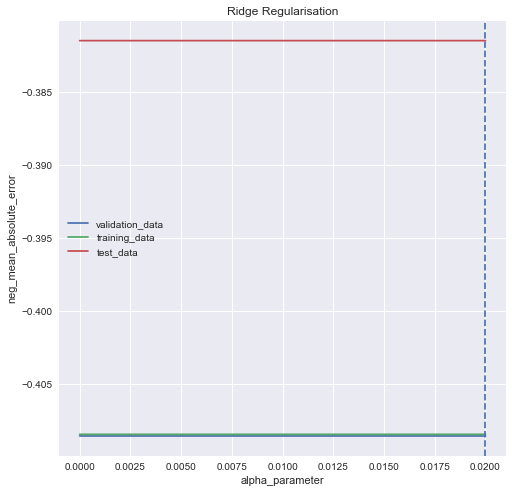

Chosen alpha: 0.02000
Validation score: -0.40857
Test score at chosen alpha: -0.38148


In [251]:
chosen_alpha, max_validation_score, test_score_at_chosen_alpha = \
    regmodel_param_test(
        lasso_alphas, X_train_scaled, y_train, 
        cv, scoring = 'neg_mean_absolute_error', model_name = 'Ridge', 
        X_test = X_test_scaled, y_test =y_test, 
        draw_plot = True, filename = 'lasso_wide_search')
print("Chosen alpha: %.5f" % \
    chosen_alpha)
print("Validation score: %.5f" % \
    max_validation_score)
print("Test score at chosen alpha: %.5f" % \
    test_score_at_chosen_alpha)

In [218]:
X_test_RF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39842 entries, 0 to 39849
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   product_id                39842 non-null  object        
 1   order_purchase_timestamp  39842 non-null  datetime64[ns]
 2   demand                    39842 non-null  int64         
 3   price                     39842 non-null  float64       
 4   freight_value             39842 non-null  float64       
 5   category_frequency        39842 non-null  float64       
 6   cumulative_demand         39842 non-null  float64       
 7   revenue                   39842 non-null  float64       
 8   weekday_number            39842 non-null  int64         
 9   month_number              39842 non-null  int64         
 10  year_number               39842 non-null  int64         
 11  is_holiday                39842 non-null  bool          
 12  sales_margin      

In [219]:
X_test_RF.columns,X_test.columns

(Index(['product_id', 'order_purchase_timestamp', 'demand', 'price',
        'freight_value', 'category_frequency', 'cumulative_demand', 'revenue',
        'weekday_number', 'month_number', 'year_number', 'is_holiday',
        'sales_margin', 'log_price', 'coef_log_price', 'avg_price_last_3_days',
        'category_mean_demand', 'product_category_name', 'inc_price',
        'dec_price', 'est_demand'],
       dtype='object'),
 Index(['product_id', 'order_purchase_timestamp', 'demand', 'price',
        'freight_value', 'product_category_name', 'product_name_lenght',
        'product_description_lenght', 'product_photos_qty', 'product_weight_g',
        'product_length_cm', 'product_height_cm', 'product_width_cm', 'cluster',
        'category_frequency', 'category_mean_demand', 'avg_price_last_3_days',
        'cumulative_demand', 'revenue', 'weekday_name', 'weekday_number',
        'month_number', 'month_name', 'year_number', 'week_year', 'week_number',
        'is_holiday', 'sales_margi

# Optimization

Following the application of the price elasticity of demand concept, three distinct pricing options for a product are identified, along with the respective demand levels at each price. The next step involves selecting one of these pricing strategies to ensure maximization of revenue per product, per day. Given three price points per product per day, one of three prices is selected that maximizes the revenue, which is essentially an optimization problem.

In [252]:
X_test_RF.shape

(39842, 27)

In [253]:
X_test_RF['inc_price'] = X_test_RF['price'] * 1.30
X_test_RF['dec_price'] = X_test_RF['price'] * 0.70
X_test_RF['inc_nf'] = X_test_RF['est_demand'] * (1 + (X_test_RF['coef_log_price'] * 0.30))
X_test_RF['dec_nf'] = X_test_RF['est_demand'] * (1 + (X_test_RF['coef_log_price'] * -0.30))

C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\727805886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_RF['inc_price'] = X_test_RF['price'] * 1.30
C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\727805886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_RF['dec_price'] = X_test_RF['price'] * 0.70
C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\727805886.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [254]:
X_test_RF.shape

(39842, 31)

In [255]:
X_test_RF['prices']= X_test_RF[['dec_price','price','inc_price']].values.tolist()
X_test_RF['demands']= X_test_RF[['dec_nf','est_demand','inc_nf']].values.tolist()


C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\1686261414.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_RF['prices']= X_test_RF[['dec_price','price','inc_price']].values.tolist()
C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\1686261414.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_RF['demands']= X_test_RF[['dec_nf','est_demand','inc_nf']].values.tolist()


In [256]:
X_test_RF.shape

(39842, 33)

In [257]:
X_test_RF['prices']

0                    [227.49999999999997, 325.0, 422.5]
1                    [227.49999999999997, 325.0, 422.5]
2                             [77.693, 110.99, 144.287]
3        [13.929999999999998, 19.9, 25.869999999999997]
4                      [37.73, 53.9, 70.07000000000001]
                              ...                      
39845                           [118.86, 169.8, 220.74]
39846              [59.492999999999995, 84.99, 110.487]
39847                 [32.129999999999995, 45.9, 59.67]
39848                                 [4.83, 6.9, 8.97]
39849                             [101.5, 145.0, 188.5]
Name: prices, Length: 39842, dtype: object

In [258]:
len(y_pred),X_test_RF.shape

(39842, (39842, 33))

In [259]:
prices =X_test_RF['prices'].tolist()
demands =X_test_RF['demands'].tolist()
num_products =    X_test_RF.shape[0]
num_prices_per_product = 3  # Since we have 3 distinct price points per product-day record

In [260]:
# Initialize an empty LIL (List of Lists) sparse matrix

A_eq_selection = lil_matrix((num_products+1, num_products * num_prices_per_product))

# Populate the A_eq_selection matrix

for product_idx in range(num_products):
    start = product_idx * num_prices_per_product
    A_eq_selection[product_idx, start:start + num_prices_per_product] = 1

# Convert to CSR format for efficient arithmetic operations and slicing


In [261]:

price_points = np.concatenate(prices)
A_eq_selection[num_products] = price_points

A_eq_selection = A_eq_selection.tocsr()

In [262]:
A_eq_selection

<39843x119526 sparse matrix of type '<class 'numpy.float64'>'
	with 239052 stored elements in Compressed Sparse Row format>

In [263]:
required_sum = X_test_RF['price'].sum()

In [264]:
required_sum

5041682.12

In [265]:
X_test_RF.columns

Index(['product_id', 'order_purchase_timestamp', 'demand', 'price',
       'freight_value', 'category_frequency', 'cumulative_demand', 'revenue',
       'weekday_number', 'month_number', 'year_number', 'is_holiday',
       'sales_margin', 'log_price', 'coef_log_price', 'avg_price_last_3_days',
       'category_mean_demand', 'product_category_name', 'est_demand',
       'standardized_price', 'standardized_freight_value',
       'standardized_cumulative_demand', 'standardized_weekday_number',
       'standardized_is_holiday', 'standardized_avg_price_last_3_days',
       'standardized_category_mean_demand', 'standardized_month_number',
       'inc_price', 'dec_price', 'inc_nf', 'dec_nf', 'prices', 'demands'],
      dtype='object')

In [266]:
b_eq = np.concatenate((np.ones(num_products), [required_sum]))  # Replace 'required_sum' with your budget total

In [267]:
b_eq

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       1.00000000e+00, 1.00000000e+00, 5.04168212e+06])

In [268]:
X_test_RF['revenue'] = X_test_RF[['dec_price', 'dec_nf', 'price', 'demand', 'inc_price', 'inc_nf']].apply(
lambda row: [row['dec_price']*row['dec_nf'], row['price']*row['demand'], row['inc_price']*row['inc_nf']], axis=1)
revenue_list = X_test_RF['revenue'].tolist()
c = -np.concatenate(revenue_list)

# Define the bounds for the decision variables

bounds = [(0, 1)] * (num_products * num_prices_per_product)

C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\1872953262.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_RF['revenue'] = X_test_RF[['dec_price', 'dec_nf', 'price', 'demand', 'inc_price', 'inc_nf']].apply(


In [269]:
bounds

[(0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 

In [270]:
c

array([-317.1549711 , -975.        , -729.19791082, ..., -122.16204846,
       -145.        , -236.83762428])

In [271]:
revenue_list

[[317.15497109816766, 975.0, 729.1979108176887],
 [317.15497109816766, 975.0, 729.1979108176887],
 [69.43003992541544, 110.99, 159.63249728137134],
 [6.6691787835705245, 19.9, 39.35438225908331],
 [81.99967566896716, 215.6, 39.70668804334674],
 [104.92999999999999, 149.9, 194.87],
 [9.303247969269488, 13.3, 17.302539485642384],
 [34.1799861641261, 59.9, 92.26288283805154],
 [77.45031537589016, 119.9, 167.903700016204],
 [10.724307591671197, 32.0, 63.28342875832492],
 [121.9223135761023, 178.0, 236.37284621581],
 [13.919897337478403, 19.9, 25.8887620875401],
 [670.7195245545331, 949.0, 1221.7780258272958],
 [-748.8080725968124, 269.99, 2092.61756339408],
 [75.27675428097552, 109.9, 145.9403134781883],
 [52.46192463873771, 75.0, 97.57071138520139],
 [362.30584716134956, 85.0, -451.8537161567921],
 [9.3804177965899, 27.99, 55.35322409204733],
 [9.3804177965899, 27.99, 55.35322409204733],
 [76.92999999999999, 109.9, 142.87],
 [13.220405008961901, 18.9, 24.587819269070753],
 [17.48031328962

In [272]:


# Solve the linear programming problem

result = linprog(c, A_eq=A_eq_selection, b_eq=b_eq, bounds=bounds, method='highs')

# Check if the optimization was successful

if result.success:
# Get the optimal price points by reshaping the result
    optimal_price_indices = result.x.reshape(num_products, num_prices_per_product)
    print("Optimization successful.", optimal_price_indices)
else:
    print("Optimization failed.", result.message)

Optimization successful. [[ 0.  1. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]
 ...
 [-0.  0.  1.]
 [ 1.  0.  0.]
 [-0.  0.  1.]]


In [273]:
num_products,num_prices_per_product

(39842, 3)

In [274]:
optimal_price_indices = result.x.reshape(num_products, num_prices_per_product)

In [275]:
optimal_indices = np.argmax(optimal_price_indices, axis=1)

In [276]:
optimal_indices

array([1, 1, 2, ..., 2, 0, 2], dtype=int64)

In [277]:
optimal_prices = [prices[i][index] for i, index in enumerate(optimal_indices)]

print("Optimal prices for each product:", optimal_prices)

Optimal prices for each product: [325.0, 325.0, 144.287, 25.869999999999997, 53.9, 104.92999999999999, 9.31, 77.87, 155.87, 41.6, 124.6, 13.929999999999998, 664.3, 350.987, 76.92999999999999, 52.5, 59.49999999999999, 36.387, 36.387, 76.92999999999999, 13.229999999999999, 17.493, 122.99, 331.5, 32.5, 62.992999999999995, 419.92999999999995, 88.193, 325.0, 22.4, 18.720000000000002, 155.74, 66.5, 29.9, 112.0, 139.1, 73.5, 107.85600000000001, 73.42999999999999, 112.0, 99.9, 69.3, 34.3, 135.093, 25.13, 77.98700000000001, 26.88, 312.0, 155.74, 99.9, 43.4, 108.3, 129.9, 48.93, 61.599999999999994, 38.87, 135.20000000000002, 97.92999999999999, 76.92999999999999, 25.935, 49.27, 62.93, 175.37, 27.229999999999997, 34.3, 282.1, 125.92999999999999, 19.942999999999998, 20.929999999999996, 47.39, 139.29999999999998, 73.97, 189.0, 273.0, 120.0, 349.92999999999995, 24.5, 111.92999999999999, 69.92999999999999, 21.9, 21.9, 13.229999999999999, 48.93, 119.9, 119.9, 97.92999999999999, 10.493, 69.3, 259.987, 6

In [278]:
len(optimal_prices)

39842

In [279]:
X_test_RF['optimal_prices_RF'] = optimal_prices

C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\4276092152.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_RF['optimal_prices_RF'] = optimal_prices


In [280]:
X_test_RF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39842 entries, 0 to 39849
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   product_id                          39842 non-null  object        
 1   order_purchase_timestamp            39842 non-null  datetime64[ns]
 2   demand                              39842 non-null  int64         
 3   price                               39842 non-null  float64       
 4   freight_value                       39842 non-null  float64       
 5   category_frequency                  39842 non-null  float64       
 6   cumulative_demand                   39842 non-null  float64       
 7   revenue                             39842 non-null  object        
 8   weekday_number                      39842 non-null  int64         
 9   month_number                        39842 non-null  int64         
 10  year_number           

In [281]:
X_test_RF[['price','inc_price','dec_price','optimal_prices_RF']]

,price,inc_price,dec_price,optimal_prices_RF
0,325.00,422.500,227.500,325.000
1,325.00,422.500,227.500,325.000
2,110.99,144.287,77.693,144.287
3,19.90,25.870,13.930,25.870
4,53.90,70.070,37.730,53.900
...,...,...,...,...
39845,169.80,220.740,118.860,118.860
39846,84.99,110.487,59.493,110.487
39847,45.90,59.670,32.130,59.670
39848,6.90,8.970,4.830,4.830


In [282]:
(X_test_RF['price'] > X_test_RF['optimal_prices_RF']).sum()

19068

In [283]:
(X_test_RF['price'] < X_test_RF['optimal_prices_RF']).sum()

17318

In [284]:
(X_test_RF['price'] == X_test_RF['optimal_prices_RF']).sum()

3456

In [285]:
19068+17318+3456

39842

In [286]:
X_test_RF.drop(['est_demand', 'inc_price', 'dec_price','inc_nf','dec_nf','prices','demands'], axis=1, inplace=True)


C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\3720061420.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_RF.drop(['est_demand', 'inc_price', 'dec_price','inc_nf','dec_nf','prices','demands'], axis=1, inplace=True)


In [287]:
X_train_RF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59765 entries, 0 to 59774
Data columns (total 26 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   product_id                          59765 non-null  object        
 1   order_purchase_timestamp            59765 non-null  datetime64[ns]
 2   demand                              59765 non-null  int64         
 3   price                               59765 non-null  float64       
 4   freight_value                       59765 non-null  float64       
 5   category_frequency                  59765 non-null  float64       
 6   cumulative_demand                   59765 non-null  float64       
 7   revenue                             59765 non-null  float64       
 8   weekday_number                      59765 non-null  int64         
 9   month_number                        59765 non-null  int64         
 10  year_number           

In [288]:
X_train_RF['optimal_prices_RF'] = X_train_RF['price']

C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\1598082519.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_RF['optimal_prices_RF'] = X_train_RF['price']


In [289]:
X_train_RF['post'] = 0
X_test_RF['post'] = 1

C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\4133797779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_RF['post'] = 0
C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_45000\4133797779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_RF['post'] = 1


In [290]:
whole_df = pd.concat([X_train_RF, X_test_RF], axis=0)

In [291]:
whole_df.to_csv("C:/Users/akankshasaxena3/Downloads/olist/post_pre_intervention_df.csv")